# Predicting Types of Crime in Boston

## CS109A Introduction to Data Science - Final Project

**Harvard University**<br/>
**Fall 2019**<br/>
**Authors**: Shashi Kunapuli, Hillel Landman, Saif Mohammed

<hr style="height:2pt">


In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [3]:
import os 
import time 

import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
from math import radians, sin, cos, sqrt, asin

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import *

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.decomposition import PCA

import statsmodels.api as sm
from scipy import stats

#from geopy.distance import geodesic
#from geopy.geocoders import Nominatim

#from simpledbf import Dbf5
#import shapefile as shp

import tensorflow as tf

In [4]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

<hr style="height:2pt">

## Introduction

Whether on a global, national or local scale, we constantly struggle to prevent and reduce crime. Boston, MA features a higher rate of crime compared to the rest of Massachusetts and the United States, particularly with regard to violent crimes.  In this project, we analyze some of Boston’s demographic and geo-spatial features and determine if they can help predict the likelihood of different types of crime. While stopping crime is extremely difficult, we hope that if we can identify some of its strongest underlying causes, we can develop more effective measures to aid in its reduction.  

## Creating the Dataset

 ### Original 5 Categories

**Load and Clean Crimes Dataset**

We started by spatially joining our crimes dataset and neighborhoods dataset using location data in ArcGIS.

In [5]:
# Crime data: https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b/download/tmp48otqq1o.csv
# Neighborhood data: http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.csv
# Crimes mapped to neighborhoods using ArcGIS Pro
crimes = pd.read_csv('Data/Crimes_by_NBHD.csv')
crimes.head()

,Unnamed: 0,Join_Count,TARGET_FID,INCIDENT_N,OFFENSE_CO,OFFENSE__1,OFFENSE_DE,DISTRICT,REPORTING_,SHOOTING,OCCURRED_O,YEAR,MONTH,DAY_OF_WEE,HOUR,UCR_PART,STREET,Lat,Long,Location,OBJECTID_1,Name,Acres,Neighborho,SqMiles,ShapeSTAre,ShapeSTLen
0,0,1,1,I192082859,724,Auto Theft,AUTO THEFT,E18,519,NaN,2019-10-13,2019,10,Sunday,9,Part One,LINCOLN ST,42.259518,-71.121563,"(42.25951765, -71.12156299)",1,Hyde Park,2927.221168,10.0,4.57,1.275092e+08,66861.244955
1,1,1,2,I192082751,724,Auto Theft,AUTO THEFT,E18,493,NaN,2019-10-12,2019,10,Saturday,20,Part One,METROPOLITAN AVE,42.262092,-71.116710,"(42.26209214, -71.11670964)",2,Hyde Park,2927.221168,10.0,4.57,1.275092e+08,66861.244955
2,2,1,3,I192082680,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,D14,794,NaN,2019-10-12,2019,10,Saturday,15,Part One,ALLSTON ST,42.352375,-71.135096,"(42.35237455, -71.13509584)",3,Allston,998.534479,24.0,1.56,4.349599e+07,37859.091242
3,3,1,4,I192082577,724,Auto Theft,AUTO THEFT,D4,130,NaN,2019-10-12,2019,10,Saturday,4,Part One,SAINT JAMES AVE,42.349476,-71.076402,"(42.34947586, -71.07640150)",4,Back Bay,399.314411,2.0,0.62,1.739407e+07,19455.671147
4,4,1,5,I192079582,727,Auto Theft,AUTO THEFT - LEASED/RENTED VEHICLE,A15,47,NaN,2019-10-02,2019,10,Wednesday,8,Part One,N MEAD ST,42.381846,-71.066551,"(42.38184582, -71.06655134)",5,Charlestown,871.541223,4.0,1.36,3.796418e+07,57509.688645


All offense categories:

In [7]:
crimes['OFFENSE__1'].unique()

array(['Auto Theft', 'Investigate Property', 'Vandalism',
       'Verbal Disputes', 'Motor Vehicle Accident Response',
       'Investigate Person', 'Aggravated Assault', 'Residential Burglary',
       'Larceny', 'Firearm Violations', 'Medical Assistance',
       'Simple Assault', 'Missing Person Reported', 'Robbery',
       'Property Lost', 'Violations', 'Warrant Arrests',
       'Firearm Discovery', 'Other', 'Ballistics', 'Towed',
       'Drug Violation', 'Fire Related Reports', 'Fraud',
       'Disorderly Conduct', 'Larceny From Motor Vehicle',
       'Police Service Incidents', 'Missing Person Located', 'Harassment',
       'Property Found', 'Liquor Violation', 'Property Related Damage',
       'Confidence Games', 'Commercial Burglary',
       'Recovered Stolen Property', 'Other Burglary',
       'Assembly or Gathering Violations', 'Counterfeiting',
       'Prisoner Related Incidents', 'License Plate Related Incidents',
       'Restraining Order Violations', 'Search Warrants',
     

We selected only the columns and crimes that we will be using and then labeled each crime as one of our five categories:

In [8]:
# Select only the columns we will be using
cols_needed = ['OFFENSE__1', 'DISTRICT', 'REPORTING_', 'YEAR', 'MONTH', 'DAY_OF_WEE', 'HOUR', 'Lat', 'Long', 'Name', 'SqMiles']
crimes1 = pd.DataFrame(crimes.copy()).drop(columns=crimes.columns.difference(cols_needed))

In [9]:
# Establish crime categories
violent = ['Aggravated Assault', 'Homicide', 'Manslaughter', 'Robbery']
break_in = ['Burglary - No Property Taken', 'HOME INVASION', 'Other Burglary', 'Residential Burglary']
larceny = ['Auto Theft', 'Larceny', 'Larceny From Motor Vehicle']
property_damage = ['Arson', 'Property Related Damage', 'Vandalism']
drugs = ['Drug Violation']

all_categories = ['Aggravated Assault', 'Homicide', 'Manslaughter', 'Robbery', 
                  'Burglary - No Property Taken', 'HOME INVASION', 'Other Burglary', 'Residential Burglary', 
                  'Auto Theft', 'Larceny', 'Larceny From Motor Vehicle', 
                  'Arson', 'Property Related Damage', 'Vandalism', 
                  'Drug Violation']

In [857]:
# Drop crimes not in those categories
crimes2 = pd.DataFrame(crimes1.copy())[crimes1['OFFENSE__1'].isin(all_categories)]
crimes2.shape

(115122, 12)

In [640]:
# Categorize Crimes
crimes2['OFFENSE__1'].loc[crimes2['OFFENSE__1'].isin(violent)] = 'Violent'
crimes2['OFFENSE__1'].loc[crimes2['OFFENSE__1'].isin(break_in)] = 'Break_In'
crimes2['OFFENSE__1'].loc[crimes2['OFFENSE__1'].isin(larceny)] = 'Larceny'
crimes2['OFFENSE__1'].loc[crimes2['OFFENSE__1'].isin(property_damage)] = 'Property_Damage'
crimes2['OFFENSE__1'].loc[crimes2['OFFENSE__1'].isin(drugs)] = 'Drugs'

In [641]:
# Rename crime type column
crimes2.rename(columns={"OFFENSE__1": "Crime_Type"}, inplace=True)
crimes2.shape

(115122, 12)

We created a version of our dataset using dummy variables for Crime Type. We may use this later on.

In [692]:
# Convert Crime_Type, YEAR, MONTH, DAY_OF_WEE, HOUR, UCR_PART to dummies
crimes_dum = pd.get_dummies(crimes2, columns=['Crime_Type'], drop_first=False)

In [693]:
# Convert SHOOTING to binary variable
crimes_dum['SHOOTING'].loc[crimes_dum['SHOOTING'].notna()] = 1
crimes_dum['SHOOTING'].loc[crimes_dum['SHOOTING'].isna()] = 0

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


We added a binary 'NIGHT' feature, categorizing crimes occuring between 9pm and 4am as night-time crimes:

In [699]:
crimes_dum['NIGHT'] = 0
crimes_dum['NIGHT'][(crimes_dum['HOUR'] >= 21)] = 1
crimes_dum['NIGHT'][(crimes_dum['HOUR'] <= 4)] = 1

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [694]:
# Crimes by Neighborhood dataset with dummy variables
crimes_dum = crimes_dum.dropna()
crimes_dum.head()

,DISTRICT,REPORTING_,SHOOTING,YEAR,MONTH,DAY_OF_WEE,HOUR,Lat,Long,Name,SqMiles,Crime_Type_Break_In,Crime_Type_Drugs,Crime_Type_Larceny,Crime_Type_Property_Damage,Crime_Type_Violent
0,E18,519,0,2019,10,Sunday,9,42.259518,-71.121563,Hyde Park,4.57,0,0,1,0,0
1,E18,493,0,2019,10,Saturday,20,42.262092,-71.116710,Hyde Park,4.57,0,0,1,0,0
2,D14,794,0,2019,10,Saturday,15,42.352375,-71.135096,Allston,1.56,0,0,1,0,0
3,D4,130,0,2019,10,Saturday,4,42.349476,-71.076402,Back Bay,0.62,0,0,1,0,0
4,A15,47,0,2019,10,Wednesday,8,42.381846,-71.066551,Charlestown,1.36,0,0,1,0,0


#### Other predictor datasets 

We uploaded and inspected the streetlight locations dataset:

In [20]:
# https://data.boston.gov/dataset/52b0fdad-4037-460c-9c92-290f5774ab2b/resource/c2fcc1e3-c38f-44ad-a0cf-e5ea2a6585b5/download/streetlight-locations.csv
streetlights = pd.read_csv('Data/streetlight-locations.csv')

In [646]:
streetlights.head()

,the_geom,OBJECTID,TYPE,Lat,Long
0,POINT (-71.0760443807948 42.35315925057316),1,LIGHT,42.353159,-71.076044
1,POINT (-71.07538171240694 42.353347768071195),2,LIGHT,42.353348,-71.075382
2,POINT (-71.07477488057383 42.35352052068278),3,LIGHT,42.353521,-71.074775
3,POINT (-71.07440373484715 42.3535558201314),4,LIGHT,42.353556,-71.074404
4,POINT (-71.07362079549182 42.35381056415504),5,LIGHT,42.353811,-71.073621


We then imported 6 more feature datasets with location data:

In [21]:
# http://bostonopendata-boston.opendata.arcgis.com/datasets/e5a0066d38ac4e2abbc7918197a4f6af_6.csv
police = pd.read_csv('Data/Boston_Police_Stations.csv')

In [22]:
# http://bostonopendata-boston.opendata.arcgis.com/datasets/1d9509a8b2fd485d9ad471ba2fdb1f90_0.csv
public_schools = pd.read_csv('Data/Public_Schools.csv')

In [23]:
# http://bostonopendata-boston.opendata.arcgis.com/datasets/0046426a3e4340a6b025ad52b41be70a_1.csv
private_schools = pd.read_csv('Data/Non_Public_Schools.csv')

In [24]:
# http://bostonopendata-boston.opendata.arcgis.com/datasets/cb00f9248aa6404ab741071ca3806c0e_6.csv
libraries = pd.read_csv('Data/Public_Libraries.csv')

In [25]:
# http://bostonopendata-boston.opendata.arcgis.com/datasets/acedd06b39854088b0f2fefccffebf84_0.csv
community_centers = pd.read_csv('Data/Community_Centers.csv')

In [26]:
# http://bostonopendata-boston.opendata.arcgis.com/datasets/cbf14bb032ef4bd38e20429f71acb61a_2.csv
colleges_and_universities = pd.read_csv('Data/Colleges_and_Universities.csv')

##### Property Value Dataset

We then uploaded Boston property value data, which assigns each property a "Parcel ID" (PID). Since many parcels had multiple units, each with their own property value, we grouped the dataset by PID and aggregated property values as sums:

In [27]:
# https://data.boston.gov/dataset/e02c44d2-3c64-459c-8fe2-e1ce5f38a035/resource/695a8596-5458-442b-a017-7cd72471aade/download/fy19fullpropassess.csv
property_assessment = pd.read_csv('Data/prop_assess_2019.csv')

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,60) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
# Drop NAs
property_assessment = property_assessment.dropna(subset=['ST_NAME_SUF'])

In [29]:
property_assessment.shape

(174129, 75)

In [30]:
# Group total property value by address
# Use highest Parcel ID for 
props = property_assessment.groupby(['PID']).agg({
    'AV_TOTAL': np.sum,
}).reset_index()

In [31]:
props.head()

,PID,AV_TOTAL
0,100001000,541200
1,100002000,596100
2,100003000,542500
3,100004000,518300
4,100005000,528400


Next, we uploaded a "Live Street Address Management" dataset, which has latitude and longitude coordinates for each PID in Boston. We merged this with our property values data to give our properties location data:

In [32]:
# Addresses to lat/long coords: http://bostonopendata-boston.opendata.arcgis.com/datasets/b6bffcace320448d96bb84eabb8a075f_0.csv
# Used data downloaded on 11/19/2019
addresses = pd.read_csv('Data/Live_Street_Address_Management_SAM_Addresses.csv')

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8,9,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
addresses.rename(columns={"PARCEL": "PID"}, inplace=True)

In [34]:
addresses.head()

,X,Y,SAM_ADDRESS_ID,RELATIONSHIP_TYPE,BUILDING_ID,FULL_ADDRESS,STREET_NUMBER,IS_RANGE,RANGE_FROM,RANGE_TO,UNIT,FULL_STREET_NAME,STREET_ID,STREET_PREFIX,STREET_BODY,STREET_SUFFIX_ABBR,STREET_FULL_SUFFIX,STREET_SUFFIX_DIR,STREET_NUMBER_SORT,MAILING_NEIGHBORHOOD,ZIP_CODE,X_COORD,Y_COORD,SAM_STREET_ID,WARD,PRECINCT_WARD,PID
0,-71.054501,42.294869,1206,1,189198,22 Agawam St,22,0,NaN,NaN,NaN,Agawam St,36,,Agawam,St,Street,,22.0,Dorchester,2122.0,776696.960383,2.932789e+06,36,16,1605,1.600383e+09
1,-71.054691,42.295129,1207,1,189188,23 Agawam St,23,0,NaN,NaN,NaN,Agawam St,36,,Agawam,St,Street,,23.0,Dorchester,2122.0,776645.061375,2.932884e+06,36,16,1605,1.600374e+09
2,-71.054621,42.294809,1208,1,189197,26 Agawam St,26,0,NaN,NaN,NaN,Agawam St,36,,Agawam,St,Street,,26.0,Dorchester,2122.0,776664.608735,2.932767e+06,36,16,1605,1.600382e+09
3,-71.053941,42.295029,1209,1,189202,6 Agawam St,6,0,NaN,NaN,NaN,Agawam St,36,,Agawam,St,Street,,6.0,Dorchester,2122.0,776848.162335,2.932849e+06,36,16,1605,1.600387e+09
4,-71.106381,42.262949,1213,1,202811,1 Agnes Ave,1,0,NaN,NaN,NaN,Agnes Ave,37,,Agnes,Ave,Avenue,,1.0,Mattapan,2126.0,762714.580914,2.921088e+06,37,18,1805,1.804358e+09


In [35]:
# Deal with duplicate PIDs - only use max
XYs = addresses.groupby(['PID']).agg({
    'X': np.max,
    'Y': np.max
}).reset_index()

In [36]:
XYs.shape

(86730, 3)

In [37]:
# Merge datasets on PID in order to get coordinate data for each parcel
properties_XY = pd.merge(props, XYs[['X', 'Y', 'PID']], on=['PID'])

In [38]:
properties_XY.head()

,PID,AV_TOTAL,X,Y
0,100001000,541200,-71.032545,42.379420
1,100002000,596100,-71.032541,42.379452
2,100003000,542500,-71.032461,42.379459
3,100004000,518300,-71.032401,42.379479
4,100005000,528400,-71.032341,42.379519


#### Calculating Predictor Distance to Crimes

We instantiated a haversine function to calculate feature distances based on latitude/longitude coordinates. We adapted this function so that we could use numpy to process many calculations. This sped up the process tremendously.

In [18]:
# https://rosettacode.org/wiki/Haversine_formula#Python, adapted for numpy
def haversine_np(lat1, lat2, lon1, lon2):
    R = 6372.8*1000  # Earth radius in meters
    
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)
    
    dLat = lat2 - lat1
    dLon = lon2 - lon1
 
    a = np.sin(dLat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
 
    return R*c

For each crime, we calculated the minimum of the distances to all streetlights, to be used as our "Distance to Nearest Streetlight" feature:

In [865]:
%%time

distances = np.zeros((len(crimes_dum)))
light_density = np.zeros((len(crimes_dum)))

for i in range(len(crimes_dum)):
    dists = haversine_np(crimes_dum["Lat"].iloc[i], streetlights["Lat"], crimes_dum["Long"].iloc[i], streetlights["Long"])
    distances[i] = dists.min()
    one_block = np.where(dists<80)
    light_density[i] = len(streetlights['Lat'].iloc[one_block])

Wall time: 9min 58s


We did the same for our other landmark predictors:

In [664]:
%%time

distances_police = np.zeros((len(crimes_dum)))
distances_pub_sch = np.zeros((len(crimes_dum)))
distances_priv_sch = np.zeros((len(crimes_dum)))
distances_lib = np.zeros((len(crimes_dum)))
distances_ccenters = np.zeros((len(crimes_dum)))
distances_univ = np.zeros((len(crimes_dum)))

for i in range(len(crimes_dum)):
    distances_police[i] = haversine_np(crimes_dum["Lat"].iloc[i], police["Y"], crimes_dum["Long"].iloc[i], police["X"]).min()
    distances_pub_sch[i] = haversine_np(crimes_dum["Lat"].iloc[i], public_schools["Y"], crimes_dum["Long"].iloc[i], public_schools["X"]).min()
    distances_priv_sch[i] = haversine_np(crimes_dum["Lat"].iloc[i], private_schools["Y"], crimes_dum["Long"].iloc[i], private_schools["X"]).min()
    distances_lib[i] = haversine_np(crimes_dum["Lat"].iloc[i], libraries["Y"], crimes_dum["Long"].iloc[i], libraries["X"]).min()
    distances_ccenters[i] = haversine_np(crimes_dum["Lat"].iloc[i], community_centers["Y"], crimes_dum["Long"].iloc[i], community_centers["X"]).min()
    distances_univ[i] = haversine_np(crimes_dum["Lat"].iloc[i], colleges_and_universities["Latitude"], crimes_dum["Long"].iloc[i], colleges_and_universities["Longitude"]).min()


Wall time: 19min 38s


We added these features to our dataset:

In [695]:
crimes_dum['Police_Station_Distance'] = distances_police
crimes_dum['Public_School_Distance'] = distances_pub_sch
crimes_dum['Private_School_Distance'] = distances_priv_sch
crimes_dum['Library_Distance'] = distances_lib
crimes_dum['Community_Center_Distance'] = distances_ccenters
crimes_dum['College_Univ_Distance'] = distances_univ
crimes_dum['Streetlight_Distance'] = distances
crimes_dum['Streetlight_Density'] = light_density

In [696]:
crimes_dum.head()

,DISTRICT,REPORTING_,SHOOTING,YEAR,MONTH,DAY_OF_WEE,HOUR,Lat,Long,Name,...,Crime_Type_Property_Damage,Crime_Type_Violent,Police_Station_Distance,Public_School_Distance,Private_School_Distance,Library_Distance,Community_Center_Distance,College_Univ_Distance,Streetlight_Distance,Streetlight_Density
0,E18,519,0,2019,10,Sunday,9,42.259518,-71.121563,Hyde Park,...,0,0,404.570388,441.081360,244.122104,272.569974,347.152835,1114.657755,114.282267,43.0
1,E18,493,0,2019,10,Saturday,20,42.262092,-71.116710,Hyde Park,...,0,0,881.314782,105.315564,560.081626,712.275560,722.201985,1044.992439,49.230388,24.0
2,D14,794,0,2019,10,Saturday,15,42.352375,-71.135096,Allston,...,0,0,1315.114311,216.971459,667.705747,1034.796609,206.430802,789.606903,15.303744,127.0
3,D4,130,0,2019,10,Saturday,4,42.349476,-71.076402,Back Bay,...,0,0,1262.034971,177.994602,347.013102,202.907717,955.584166,169.973602,8.236943,266.0
4,A15,47,0,2019,10,Wednesday,8,42.381846,-71.066551,Charlestown,...,0,0,1050.159873,312.623878,983.996620,692.733689,78.116124,493.226999,11.917140,211.0


Then, for each crime, we used our haversine function to calculate its distance to all properties in meters. We filtered by a distance less than 240m, which is the approximate length of three city blocks. For each crime we summed the total value for all properties within that three block radius, and added that data to our dataset:

In [669]:
%%time

# Find total value of all properties within a three block (240m) radius 
three_block_val = np.zeros(len(crimes_dum))
three_block_mean = np.zeros(len(crimes_dum))
three_block_var = np.zeros(len(crimes_dum))

for i in range(len(crimes_dum)):
    distances_props = haversine_np(crimes_dum["Lat"].iloc[i], properties_XY["Y"], crimes_dum["Long"].iloc[i], properties_XY["X"])
    three_blocks = np.where(distances_props<240)
    three_block_val[i] = np.sum(properties_XY['AV_TOTAL'].iloc[three_blocks])
    three_block_mean[i] = np.mean(properties_XY['AV_TOTAL'].iloc[three_blocks])
    three_block_var[i] = np.var(properties_XY['AV_TOTAL'].iloc[three_blocks])

Wall time: 12min 32s


In [697]:
crimes_dum['Property_Total'] = three_block_val
crimes_dum['Property_Avg'] = three_block_mean
crimes_dum['Property_Var'] = three_block_var

In [698]:
crimes_dum = crimes_dum[crimes_dum['Property_Total'] != 0]

In [10]:
crimes_dum['DAY_OF_WEE'] = crimes_dum['DAY_OF_WEE'].map({
    'Tuesday':2, 
    'Saturday':6, 
    'Monday':1, 
    'Sunday':7, 
    'Thursday':4, 
    'Wednesday':3,
    'Friday':5
})

In [11]:
crimes_dum['DISTRICT'] = crimes_dum['DISTRICT'].map({
    'B3':1, 
    'E18':2, 
    'B2':3, 
    'E5':4, 
    'C6':5, 
    'D14':6, 
    'E13':7, 
    'C11':8, 
    'D4':9, 
    'A7':10, 
    'A1':11, 
    'A15':12
})

In [700]:
# Add catergories back in
cd2 = pd.concat([crimes_dum, crimes2['Crime_Type']], axis=1)
cd2 = cd2.dropna()

In [13]:
Crimes_Full2 = 'Data/Crimes_Full2.csv'
# if os.path.exists(Crimes_Full2):
#     os.remove(Crimes_Full2)

# crimes_full2.to_csv(Crimes_Full2)

In [14]:
crimes_full2 = pd.read_csv(Crimes_Full2)

### Revisiting Crime Categories

Since we were later unable to differentiate well between the original 5 crime categories, we performed some visualizations to identify categories with some spatial separation. We plotted X, Y coordinates for these crimes, which provide a clear outline of the Boston area along with concentrations of each crime within the city:

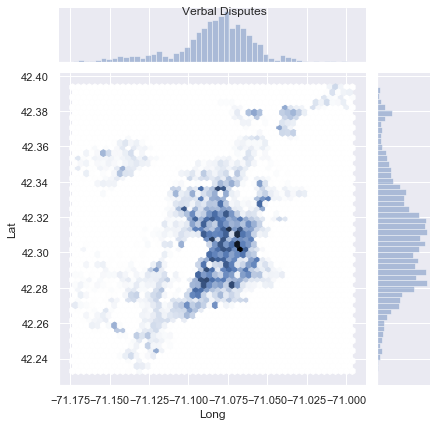

In [10]:
verb = crimes1.loc[crimes1['OFFENSE__1']=='Verbal Disputes']

sns.jointplot(verb['Long'], verb['Lat'], kind='hex')
plt.suptitle('Verbal Disputes')

plt.show()

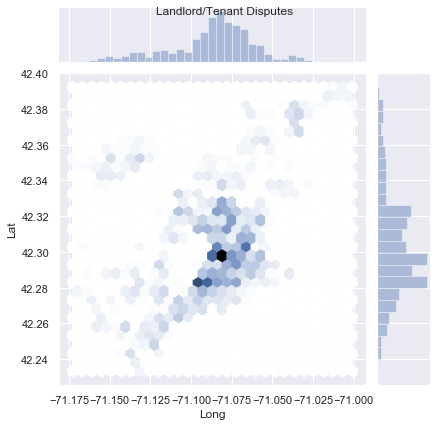

In [11]:
ltd = crimes1.loc[crimes1['OFFENSE__1']=='Landlord/Tenant Disputes']

sns.jointplot(ltd['Long'], ltd['Lat'], kind='hex')
plt.suptitle('Landlord/Tenant Disputes')

plt.show()

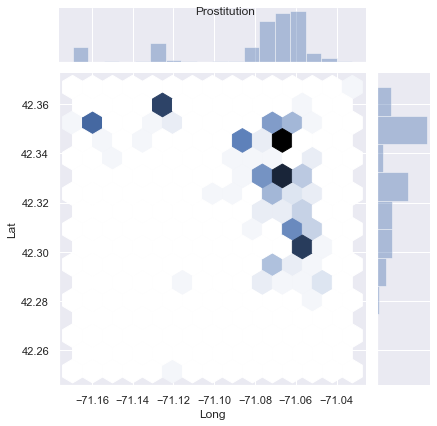

In [12]:
Prostitution = crimes1.loc[crimes1['OFFENSE__1']=='Prostitution']

sns.jointplot(Prostitution['Long'], Prostitution['Lat'], kind='hex')
plt.suptitle('Prostitution')

plt.show()

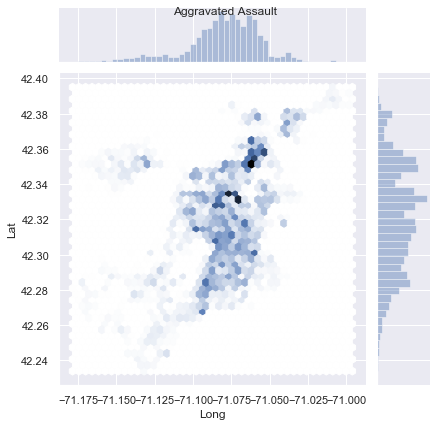

In [13]:
ag = crimes1.loc[crimes1['OFFENSE__1']=='Aggravated Assault']

sns.jointplot(ag['Long'], ag['Lat'], kind='hex')
plt.suptitle('Aggravated Assault')

plt.show()

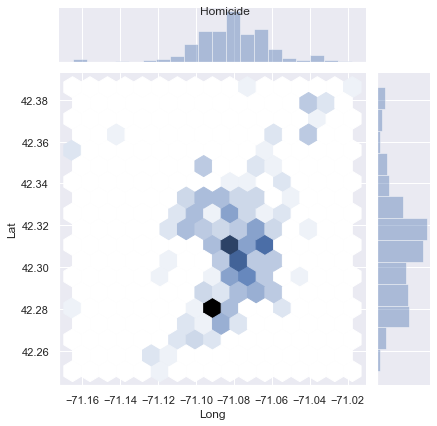

In [14]:
homicide = crimes1.loc[crimes1['OFFENSE__1']=='Homicide']

sns.jointplot(homicide['Long'], homicide['Lat'], kind='hex')
plt.suptitle('Homicide')

plt.show()

We then recreated the dataset using these 5 new categories:

In [15]:
new_categories = ['Landlord/Tenant Disputes', 'Verbal Disputes', 'Prostitution', 'Aggravated Assault', 'Homicide']

In [16]:
crimes3 = pd.DataFrame(crimes1.copy())[crimes1['OFFENSE__1'].isin(new_categories)].dropna()
crimes3.rename(columns={"OFFENSE__1": "Crime_Type"}, inplace=True)
crimes3.shape

(29230, 11)

We conducted coordinate distance calculations for our predictors:

In [39]:
%%time

distances3 = np.zeros((len(crimes3)))
light_density3 = np.zeros((len(crimes3)))

for i in range(len(crimes3)):
    dists = haversine_np(crimes3["Lat"].iloc[i], streetlights["Lat"], crimes3["Long"].iloc[i], streetlights["Long"])
    distances3[i] = dists.min()
    one_block = np.where(dists<80)
    light_density3[i] = len(streetlights['Lat'].iloc[one_block])

Wall time: 2min 21s


In [40]:
%%time

distances_police3 = np.zeros((len(crimes3)))
distances_pub_sch3 = np.zeros((len(crimes3)))
distances_priv_sch3 = np.zeros((len(crimes3)))
distances_lib3 = np.zeros((len(crimes3)))
distances_ccenters3 = np.zeros((len(crimes3)))
distances_univ3 = np.zeros((len(crimes3)))

for i in range(len(crimes3)):
    distances_police3[i] = haversine_np(crimes3["Lat"].iloc[i], police["Y"], crimes3["Long"].iloc[i], police["X"]).min()
    distances_pub_sch3[i] = haversine_np(crimes3["Lat"].iloc[i], public_schools["Y"], crimes3["Long"].iloc[i], public_schools["X"]).min()
    distances_priv_sch3[i] = haversine_np(crimes3["Lat"].iloc[i], private_schools["Y"], crimes3["Long"].iloc[i], private_schools["X"]).min()
    distances_lib3[i] = haversine_np(crimes3["Lat"].iloc[i], libraries["Y"], crimes3["Long"].iloc[i], libraries["X"]).min()
    distances_ccenters3[i] = haversine_np(crimes3["Lat"].iloc[i], community_centers["Y"], crimes3["Long"].iloc[i], community_centers["X"]).min()
    distances_univ3[i] = haversine_np(crimes3["Lat"].iloc[i], colleges_and_universities["Latitude"], crimes3["Long"].iloc[i], colleges_and_universities["Longitude"]).min()


Wall time: 5min 1s


In [41]:
crimes3['Police_Station_Distance'] = distances_police3
crimes3['Public_School_Distance'] = distances_pub_sch3
crimes3['Private_School_Distance'] = distances_priv_sch3
crimes3['Library_Distance'] = distances_lib3
crimes3['Community_Center_Distance'] = distances_ccenters3
crimes3['College_Univ_Distance'] = distances_univ3
crimes3['Streetlight_Distance'] = distances3
crimes3['Streetlight_Density'] = light_density3

In [42]:
crimes3.head()

,Crime_Type,DISTRICT,REPORTING_,YEAR,MONTH,DAY_OF_WEE,HOUR,Lat,Long,Name,SqMiles,Police_Station_Distance,Public_School_Distance,Private_School_Distance,Library_Distance,Community_Center_Distance,College_Univ_Distance,Streetlight_Distance,Streetlight_Density
7,Verbal Disputes,B3,450,2019,9,Sunday,6,42.291816,-71.072441,Dorchester,7.29,1294.698734,573.079836,266.645536,493.022243,662.780790,1712.705604,6.699160,22.0
11,Aggravated Assault,A1,75,2019,9,Sunday,4,42.364331,-71.063193,West End,0.30,365.995871,706.153883,850.480630,353.759022,722.748431,602.902936,6.413295,35.0
14,Verbal Disputes,B3,466,2019,9,Saturday,23,42.283628,-71.093496,Mattapan,2.11,191.749246,191.631906,487.781032,679.592992,869.976099,2433.586111,74.517637,1.0
16,Verbal Disputes,B3,429,2019,9,Sunday,0,42.285765,-71.087632,Dorchester,7.29,354.142836,410.533676,345.745917,1022.549119,949.870546,2071.275505,4.538379,14.0
18,Verbal Disputes,B2,311,2019,9,Sunday,0,42.317859,-71.081036,Roxbury,3.29,1231.619915,342.035958,226.083006,1098.049354,908.139672,1736.328140,11.645008,18.0


In [43]:
%%time

# Find total value of all properties within a three block (240m) radius 
three_block_val3 = np.zeros(len(crimes3))
three_block_mean3 = np.zeros(len(crimes3))
three_block_var3 = np.zeros(len(crimes3))

for i in range(len(crimes3)):
    distances_props = haversine_np(crimes3["Lat"].iloc[i], properties_XY["Y"], crimes3["Long"].iloc[i], properties_XY["X"])
    three_blocks = np.where(distances_props<240)
    three_block_val3[i] = np.sum(properties_XY['AV_TOTAL'].iloc[three_blocks])
    three_block_mean3[i] = np.mean(properties_XY['AV_TOTAL'].iloc[three_blocks])
    three_block_var3[i] = np.var(properties_XY['AV_TOTAL'].iloc[three_blocks])

Wall time: 2min 42s


In [44]:
crimes3['Property_Total'] = three_block_val3
crimes3['Property_Avg'] = three_block_mean3
crimes3['Property_Var'] = three_block_var3
crimes3 = crimes3[crimes3['Property_Total'] != 0]

In [45]:
crimes3['NIGHT'] = 0
crimes3['NIGHT'][(crimes3['HOUR'] >= 21)] = 1
crimes3['NIGHT'][(crimes3['HOUR'] <= 4)] = 1

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
crimes3['DAY_OF_WEE'] = crimes3['DAY_OF_WEE'].map({
    'Tuesday':2, 
    'Saturday':6, 
    'Monday':1, 
    'Sunday':7, 
    'Thursday':4, 
    'Wednesday':3,
    'Friday':5
})

In [47]:
crimes3['DISTRICT'] = crimes3['DISTRICT'].map({
    'B3':1, 
    'E18':2, 
    'B2':3, 
    'E5':4, 
    'C6':5, 
    'D14':6, 
    'E13':7, 
    'C11':8, 
    'D4':9, 
    'A7':10, 
    'A1':11, 
    'A15':12
})

In [69]:
crimes3.head()

,Unnamed: 0,Crime_Type,DISTRICT,REPORTING_,YEAR,MONTH,DAY_OF_WEE,HOUR,Lat,Long,Name,SqMiles,Police_Station_Distance,Public_School_Distance,Private_School_Distance,Library_Distance,Community_Center_Distance,College_Univ_Distance,Streetlight_Distance,Streetlight_Density,Property_Total,Property_Avg,Property_Var,NIGHT
0,7,Verbal Disputes,1,450,2019,9,7,6,42.291816,-71.072441,Dorchester,7.29,1294.698734,573.079836,266.645536,493.022243,662.780790,1712.705604,6.699160,22.0,1.516038e+08,6.451227e+05,5.377572e+11,0
1,11,Aggravated Assault,11,75,2019,9,7,4,42.364331,-71.063193,West End,0.30,365.995871,706.153883,850.480630,353.759022,722.748431,602.902936,6.413295,35.0,1.980411e+09,3.736624e+07,2.107007e+16,1
2,14,Verbal Disputes,1,466,2019,9,6,23,42.283628,-71.093496,Mattapan,2.11,191.749246,191.631906,487.781032,679.592992,869.976099,2433.586111,74.517637,1.0,1.310139e+08,6.122145e+05,1.842610e+12,1
3,16,Verbal Disputes,1,429,2019,9,7,0,42.285765,-71.087632,Dorchester,7.29,354.142836,410.533676,345.745917,1022.549119,949.870546,2071.275505,4.538379,14.0,1.094070e+08,4.411573e+05,6.624002e+10,1
4,18,Verbal Disputes,3,311,2019,9,7,0,42.317859,-71.081036,Roxbury,3.29,1231.619915,342.035958,226.083006,1098.049354,908.139672,1736.328140,11.645008,18.0,1.099579e+08,5.880101e+05,1.135150e+12,1


In [8]:
# Save file
cf3 = 'Data/Crimes3.csv'
# if os.path.exists(cf3):
#     os.remove(cf3)

# crimes3.to_csv(cf3)

In [9]:
crimes3 = pd.read_csv(cf3)

<hr style="height:2pt">

## Visualizations

### Original Categories

Overall crime distribution between the 5 categories:

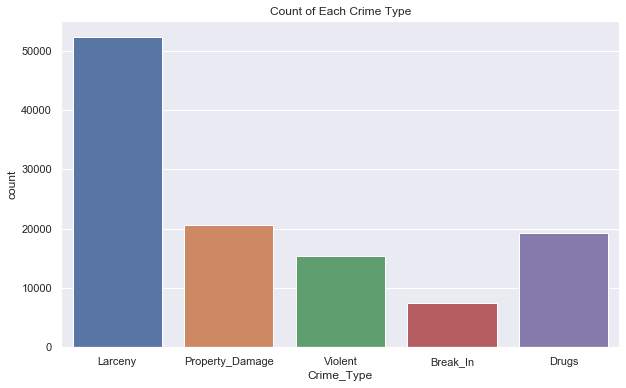

In [1002]:
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(x="Crime_Type", data=crimes_full2)

ax.set_title('Count of Each Crime Type')

plt.show()

##### Crime type by selected predictors:

Streetlight Density:

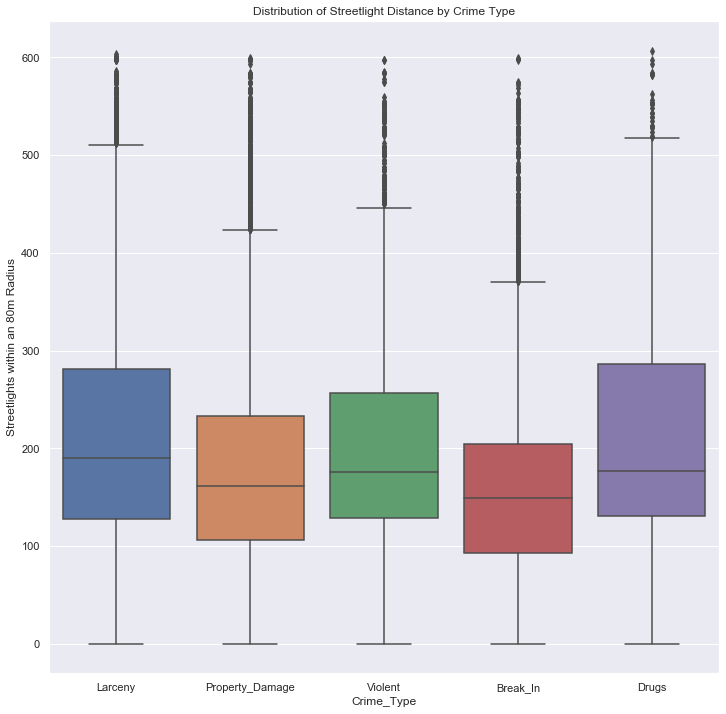

In [1005]:
fig, ax = plt.subplots(figsize=(12,12))

ax = sns.boxplot(
     data=crimes_full2,
     x='Crime_Type',
     y='Streetlight_Density')

ax.set_title('Distribution of Streetlight Density by Crime Type')
ax.set_ylabel('Streetlights within an 80m Radius')

plt.show()

Average Property Value within 3 Blocks:

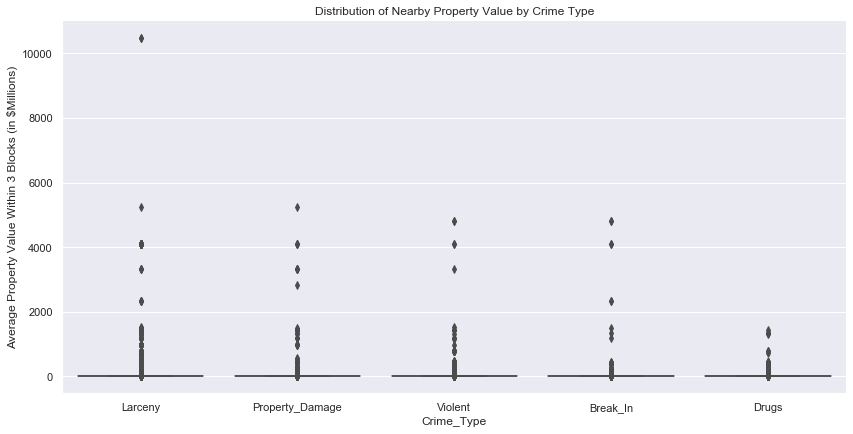

In [1060]:
sns.catplot(
    data=crimes_full2,
    x='Crime_Type',
    y='Property_Avg',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Nearby Property Value by Crime Type')
plt.ylabel('Average Property Value Within 3 Blocks (in $Millions)')

plt.show()

Removed outliers from property avg data:

In [15]:
crimes_full2['Property_Avg'] = crimes_full2['Property_Avg']/1000000

In [1058]:
crimes_full2['Property_Avg'].describe()

count    114968.000000
mean         12.865187
std         109.301520
min           0.043483
25%           0.642284
50%           1.223430
75%           6.321487
max       10486.056500
Name: Property_Avg, dtype: float64

In [1013]:
crimes_full2['Property_Avg'].quantile(.90)

22.52397454237288

In [1014]:
# 90th percentile and lower
pa_df = crimes_full2[crimes_full2['Property_Avg'] < 22.5]

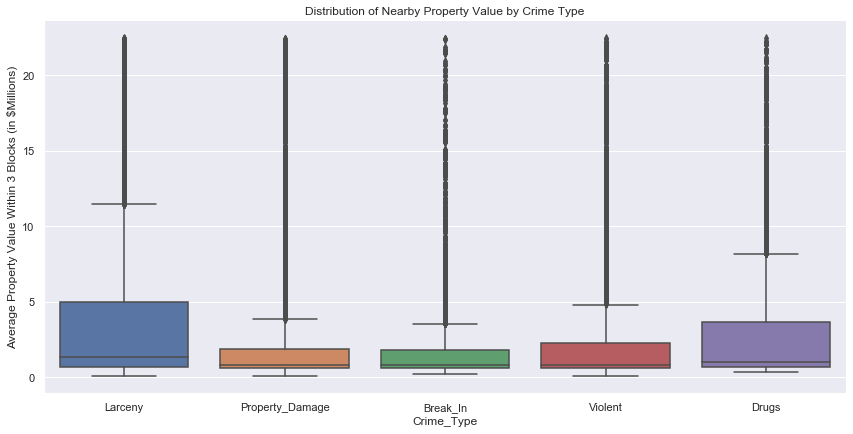

In [1061]:
sns.catplot(
    data=pa_df,
    x='Crime_Type',
    y='Property_Avg',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Nearby Property Value by Crime Type')
plt.ylabel('Average Property Value Within 3 Blocks (in $Millions)')

plt.show()

Distribution of landmark distance by crime type:

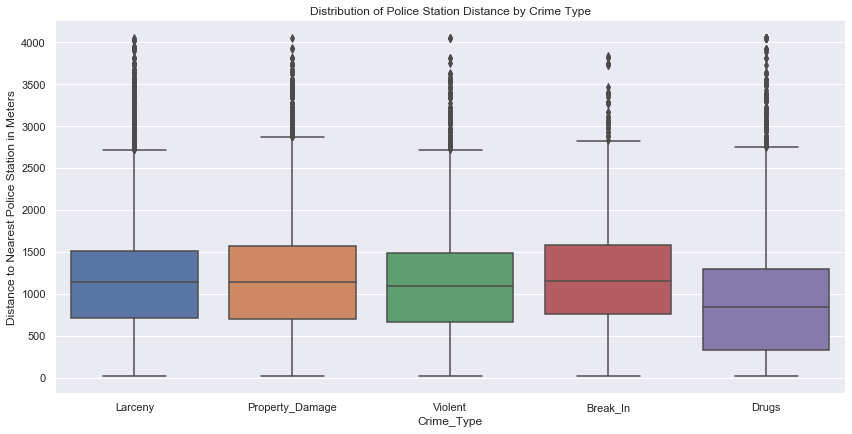

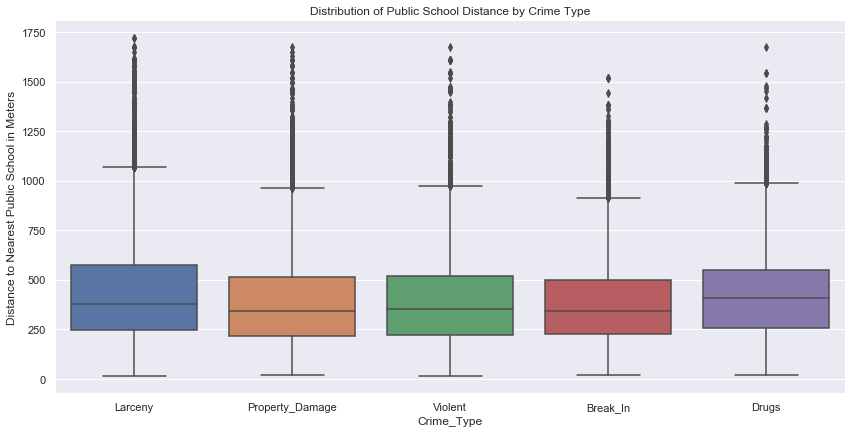

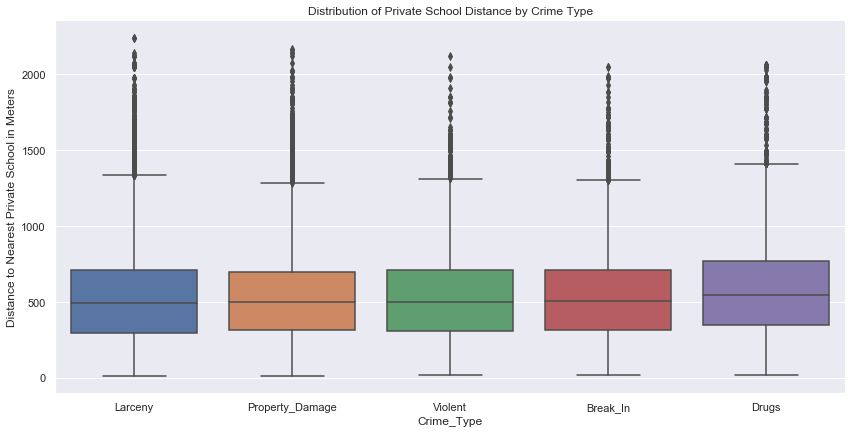

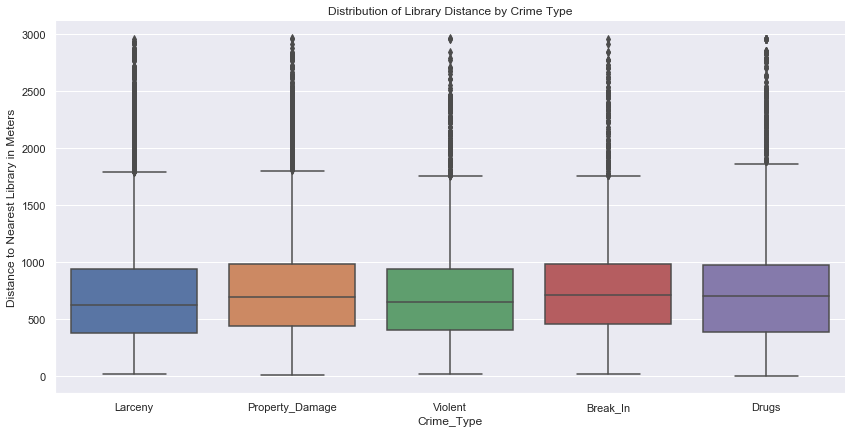

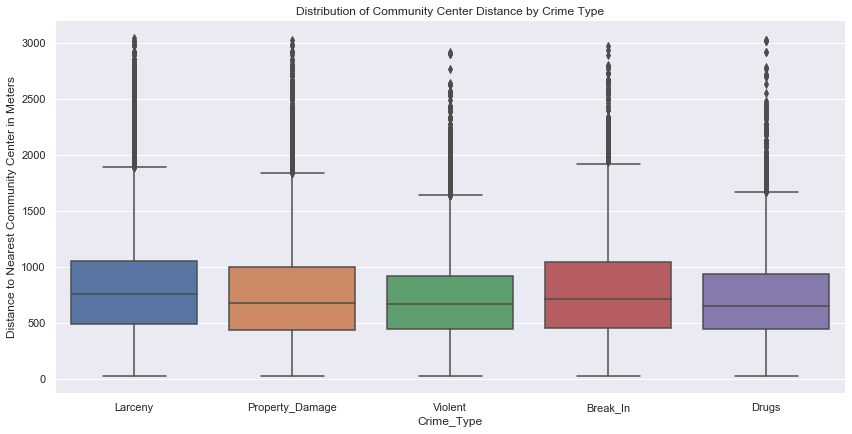

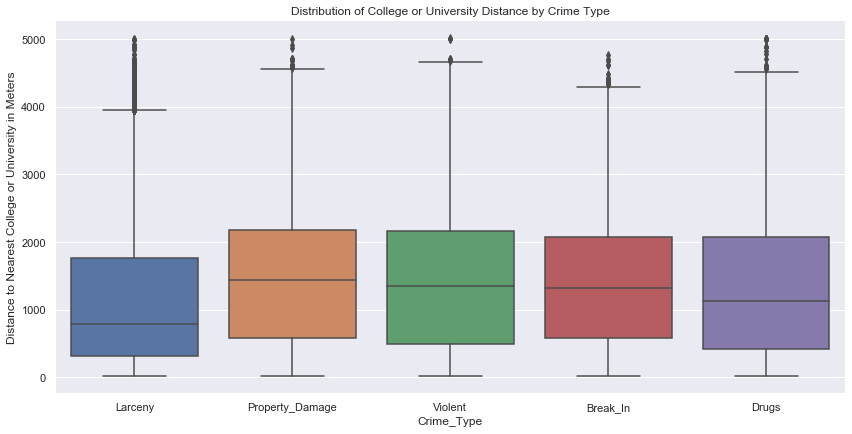

In [1025]:
sns.catplot(
    data=crimes_full2,
    x='Crime_Type',
    y='Police_Station_Distance',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Police Station Distance by Crime Type')
plt.ylabel('Distance to Nearest Police Station in Meters')


sns.catplot(
    data=crimes_full2,
    x='Crime_Type',
    y='Public_School_Distance',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Public School Distance by Crime Type')
plt.ylabel('Distance to Nearest Public School in Meters')


sns.catplot(
    data=crimes_full2,
    x='Crime_Type',
    y='Private_School_Distance',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Private School Distance by Crime Type')
plt.ylabel('Distance to Nearest Private School in Meters')


sns.catplot(
    data=crimes_full2,
    x='Crime_Type',
    y='Library_Distance',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Library Distance by Crime Type')
plt.ylabel('Distance to Nearest Library in Meters')


sns.catplot(
    data=crimes_full2,
    x='Crime_Type',
    y='Community_Center_Distance',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Community Center Distance by Crime Type')
plt.ylabel('Distance to Nearest Community Center in Meters')


sns.catplot(
    data=crimes_full2,
    x='Crime_Type',
    y='College_Univ_Distance',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of College or University Distance by Crime Type')
plt.ylabel('Distance to Nearest College or University in Meters')

plt.show()

Crime types during day and night time:

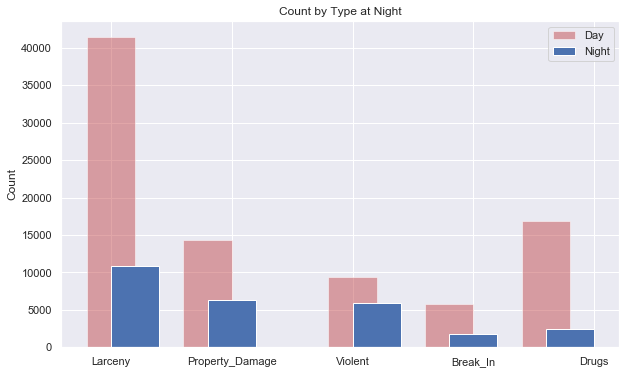

In [1027]:
fig, ax = plt.subplots(figsize=(10,6))

# Normalize per # hours - 9 in night, 15 in day
ax.hist(crimes_full2['Crime_Type'][crimes_full2['NIGHT']==0], color='r', label='Day', align='left', alpha=0.5)
ax.hist(crimes_full2['Crime_Type'][crimes_full2['NIGHT']==1], label='Night')

ax.legend()

ax.set_title('Count by Type at Night')
ax.set_ylabel('Count')

plt.show()

Scatter Matrix of select predictors:

In [1124]:
crimes_full2['Crime_Type_no'] = crimes_full2['Crime_Type'].map({
    'Larceny':1, 
    'Property_Damage':2, 
    'Violent':3, 
    'Brean_In':4, 
    'Drugs':5, 
})

In [1125]:
crimes_full2.head()

,Unnamed: 0,DISTRICT,REPORTING_,SHOOTING,YEAR,MONTH,DAY_OF_WEE,HOUR,Lat,Long,Name,SqMiles,Crime_Type_Break_In,Crime_Type_Drugs,Crime_Type_Larceny,Crime_Type_Property_Damage,Crime_Type_Violent,Police_Station_Distance,Public_School_Distance,Private_School_Distance,Library_Distance,Community_Center_Distance,College_Univ_Distance,Streetlight_Distance,Streetlight_Density,Property_Total,Property_Avg,Property_Var,NIGHT,Crime_Type,Crime_Type_#,Crime_Type_no
0,0,2,519.0,0.0,2019.0,10.0,7,9.0,42.259518,-71.121563,Hyde Park,4.57,0.0,0.0,1.0,0.0,0.0,404.570388,441.081360,244.122104,272.569974,347.152835,1114.657755,114.282267,43.0,9.306016e+07,0.528751,1.072036e+12,0.0,Larceny,1.0,1.0
1,1,2,493.0,0.0,2019.0,10.0,6,20.0,42.262092,-71.116710,Hyde Park,4.57,0.0,0.0,1.0,0.0,0.0,881.314782,105.315564,560.081626,712.275560,722.201985,1044.992439,49.230388,24.0,1.293648e+08,0.680867,7.096594e+12,0.0,Larceny,1.0,1.0
2,2,6,794.0,0.0,2019.0,10.0,6,15.0,42.352375,-71.135096,Allston,1.56,0.0,0.0,1.0,0.0,0.0,1315.114311,216.971459,667.705747,1034.796609,206.430802,789.606903,15.303744,127.0,2.860970e+08,1.673082,2.409631e+13,0.0,Larceny,1.0,1.0
3,3,9,130.0,0.0,2019.0,10.0,6,4.0,42.349476,-71.076402,Back Bay,0.62,0.0,0.0,1.0,0.0,0.0,1262.034971,177.994602,347.013102,202.907717,955.584166,169.973602,8.236943,266.0,3.366582e+09,39.146298,1.481345e+16,1.0,Larceny,1.0,1.0
4,4,12,47.0,0.0,2019.0,10.0,3,8.0,42.381846,-71.066551,Charlestown,1.36,0.0,0.0,1.0,0.0,0.0,1050.159873,312.623878,983.996620,692.733689,78.116124,493.226999,11.917140,211.0,2.292775e+08,0.686460,5.368617e+11,0.0,Larceny,1.0,1.0


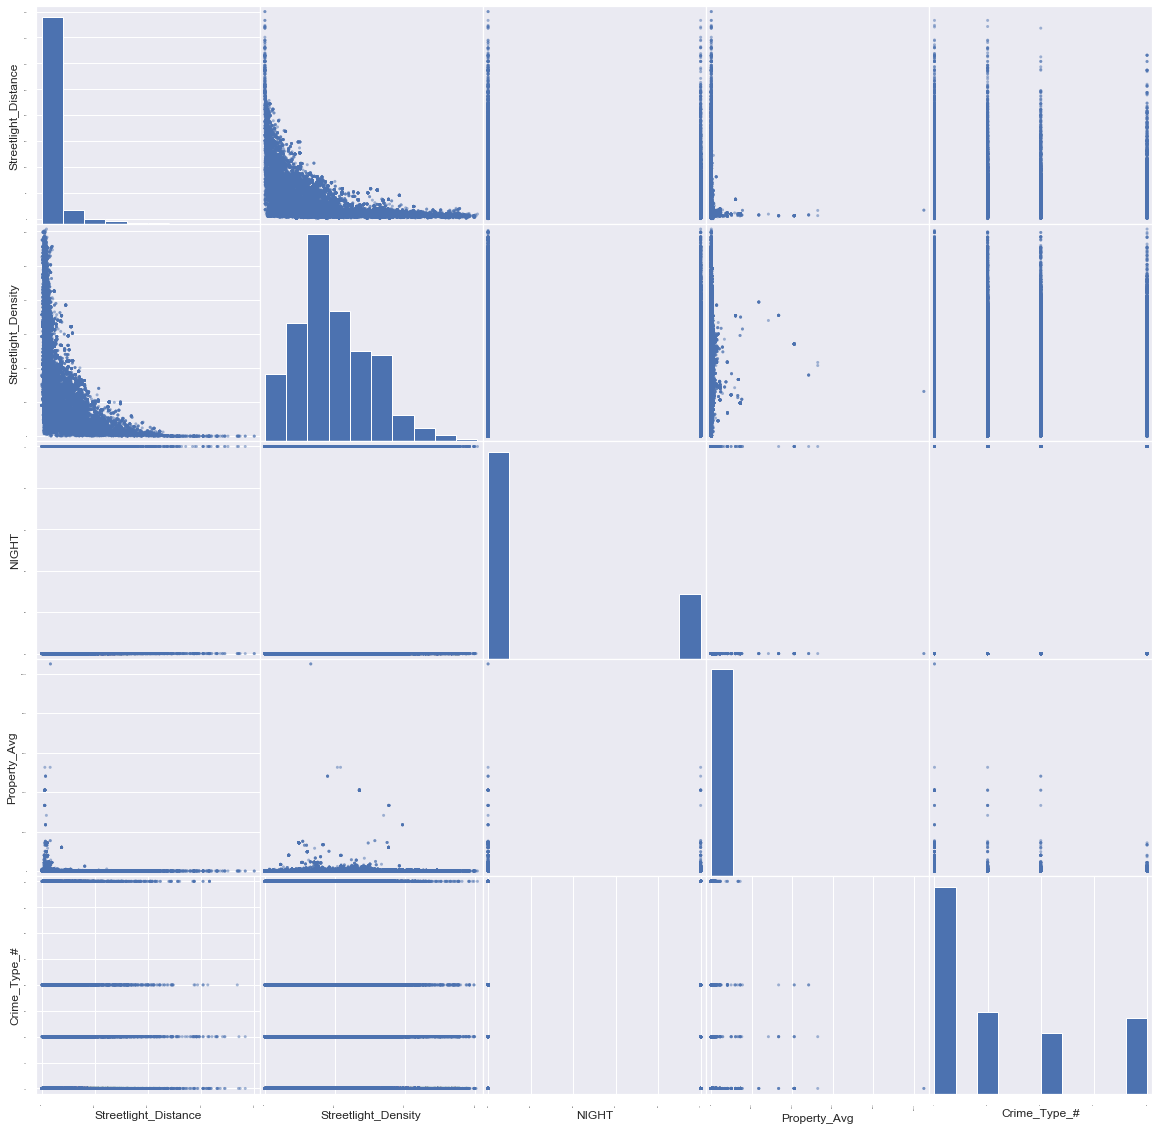

Wall time: 28.7 s


In [1035]:
%%time
pred_columns = ['Streetlight_Distance', 'Streetlight_Density', 'NIGHT',
                'Property_Avg', 'Crime_Type_no']


Axes = scatter_matrix(crimes_full2[pred_columns], alpha=0.5, figsize=(20, 20))
#y ticklabels
[plt.setp(item.yaxis.get_majorticklabels(), 'size', 2) for item in Axes.ravel()]
#x ticklabels
[plt.setp(item.xaxis.get_majorticklabels(), 'size', 2) for item in Axes.ravel()]

plt.show()

<hr style="height:1pt">

### New Categories

Overall crime distribution between the 5 categories:

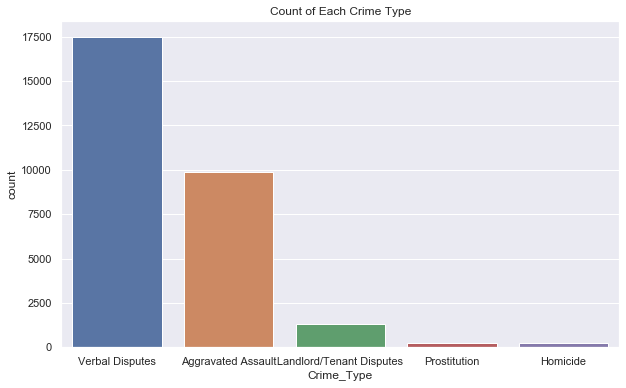

In [1041]:
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(x="Crime_Type", data=crimes3)

ax.set_title('Count of Each Crime Type')

plt.show()

##### Crime type by selected predictors:

Streetlight Density:

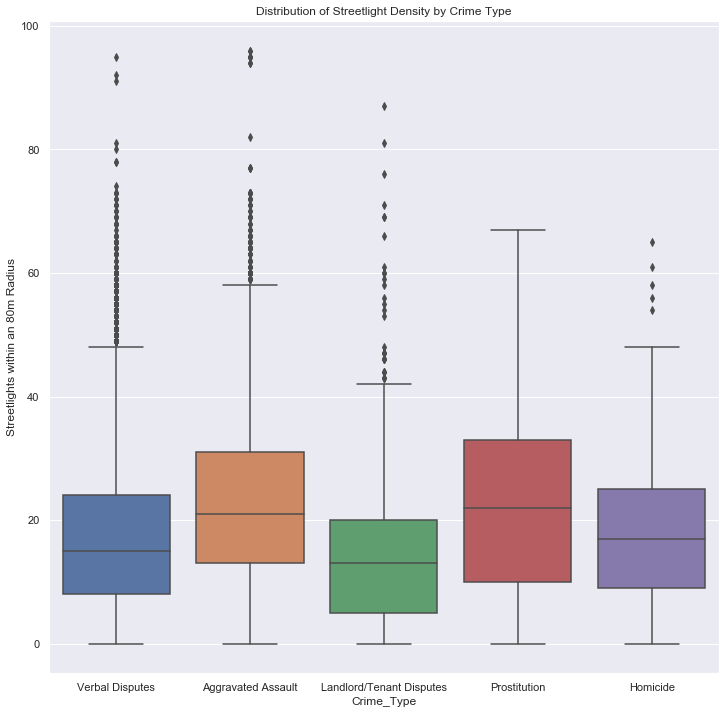

In [1042]:
fig, ax = plt.subplots(figsize=(12,12))

ax = sns.boxplot(
     data=crimes3,
     x='Crime_Type',
     y='Streetlight_Density')

ax.set_title('Distribution of Streetlight Density by Crime Type')
ax.set_ylabel('Streetlights within an 80m Radius')

plt.show()

Average Property Value within 3 Blocks:

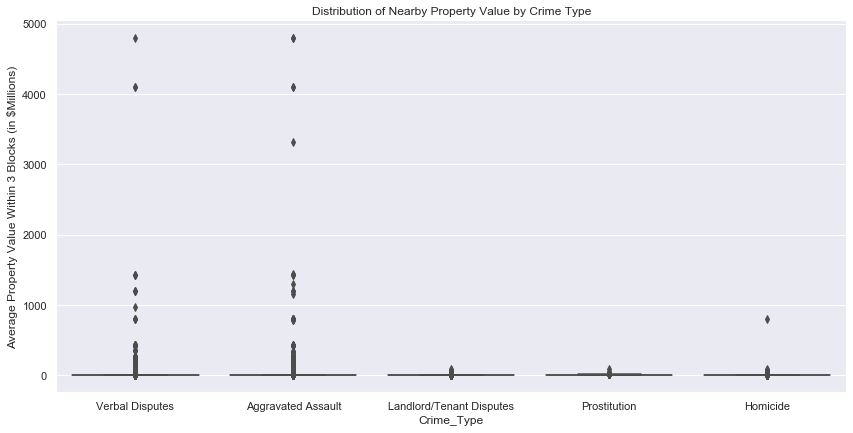

In [1051]:
sns.catplot(
    data=crimes3,
    x='Crime_Type',
    y='Property_Avg',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Nearby Property Value by Crime Type')
plt.ylabel('Average Property Value Within 3 Blocks (in $Millions)')

plt.show()

Removed outliers from property avg data:

In [16]:
crimes3['Property_Avg'] = crimes3['Property_Avg']/1000000

In [71]:
crimes3['Property_Avg'].describe()

count    29190.000000
mean         7.244980
std         80.522594
min          0.043483
25%          0.540239
50%          0.702185
75%          1.720089
max       4802.704500
Name: Property_Avg, dtype: float64

In [72]:
crimes3['Property_Avg'].quantile(.9)

11.253155620689657

In [73]:
# 90th percentile and lower
pa_df_3 = crimes3[crimes3['Property_Avg'] < 11.25]

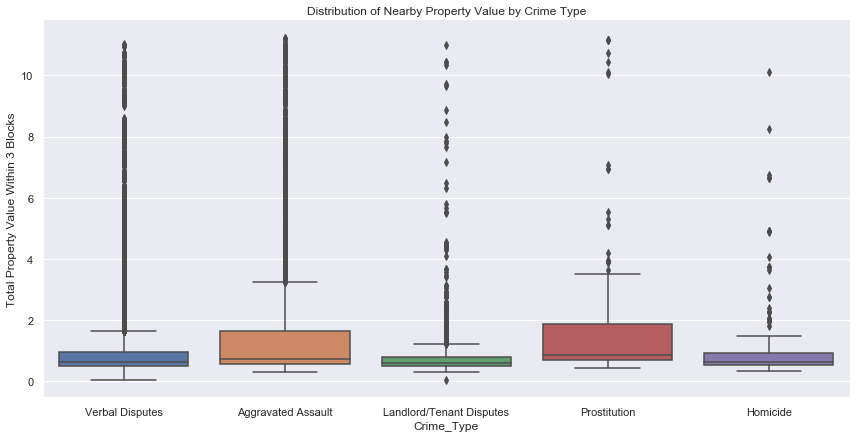

In [74]:
sns.catplot(
    data=pa_df_3,
    x='Crime_Type',
    y='Property_Avg',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Nearby Property Value by Crime Type')
plt.ylabel('Total Property Value Within 3 Blocks')

plt.show()

Distribution of landmark distance by crime type:

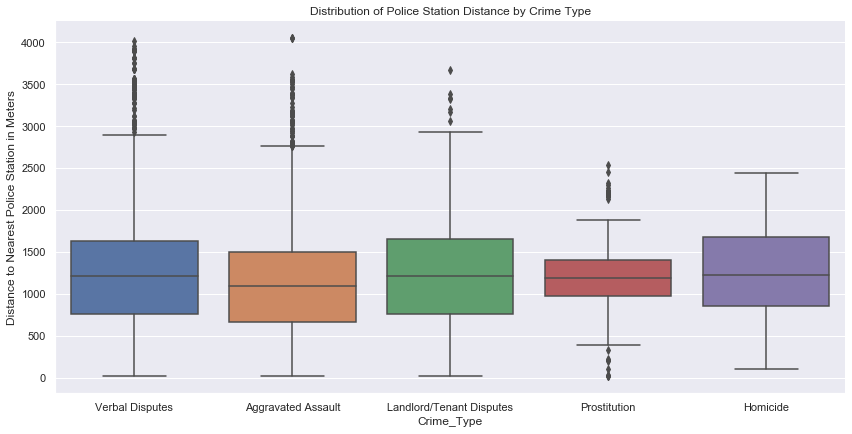

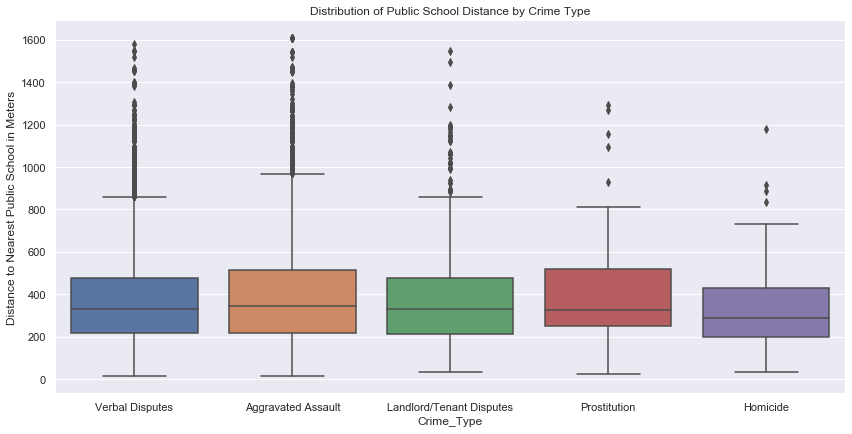

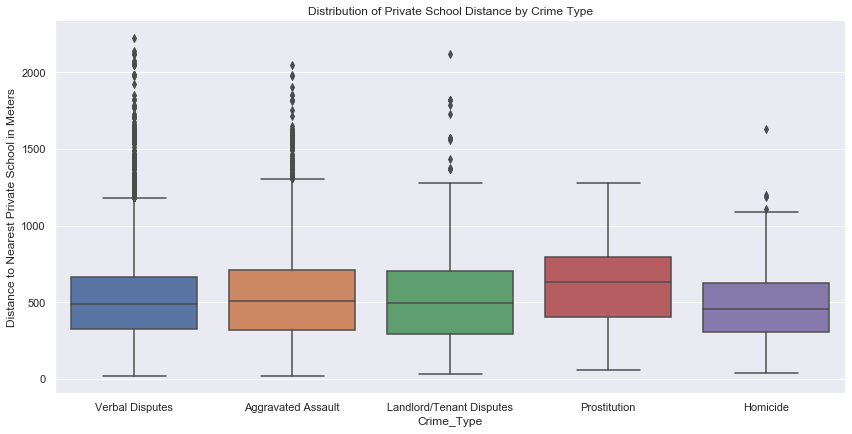

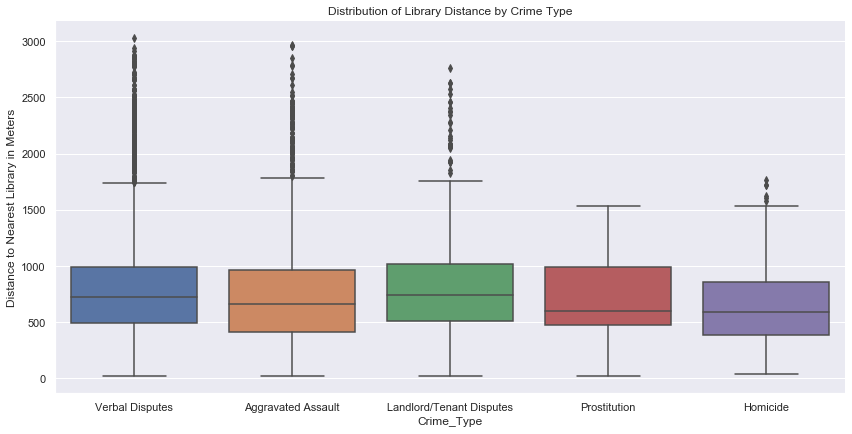

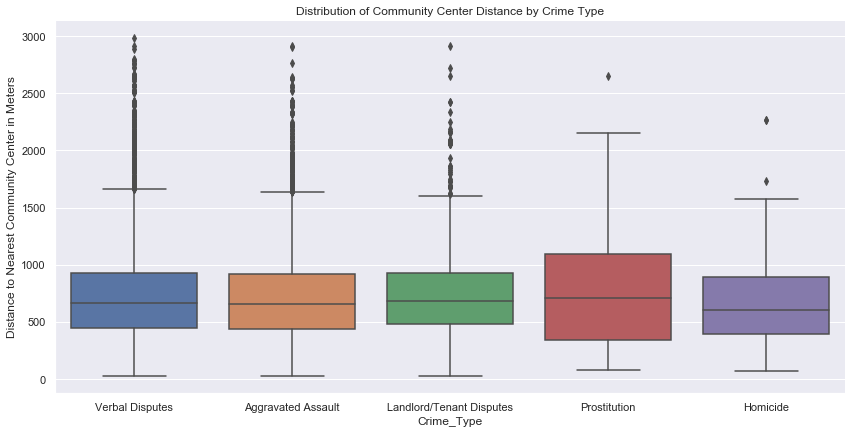

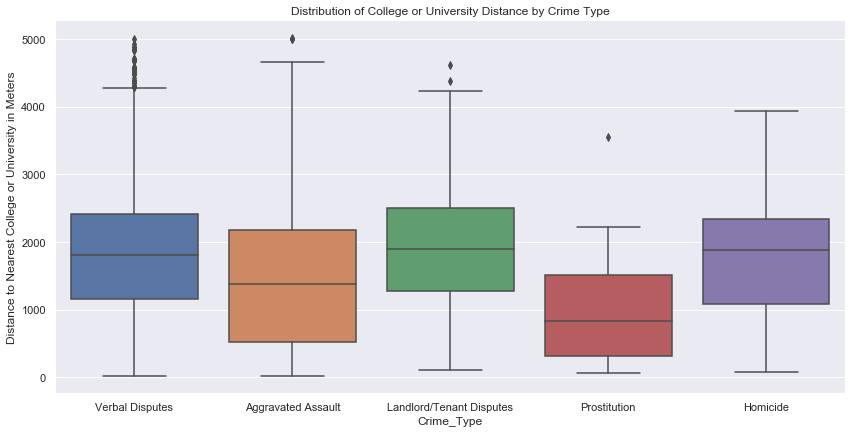

In [1067]:
sns.catplot(
    data=crimes3,
    x='Crime_Type',
    y='Police_Station_Distance',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Police Station Distance by Crime Type')
plt.ylabel('Distance to Nearest Police Station in Meters')


sns.catplot(
    data=crimes3,
    x='Crime_Type',
    y='Public_School_Distance',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Public School Distance by Crime Type')
plt.ylabel('Distance to Nearest Public School in Meters')


sns.catplot(
    data=crimes3,
    x='Crime_Type',
    y='Private_School_Distance',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Private School Distance by Crime Type')
plt.ylabel('Distance to Nearest Private School in Meters')


sns.catplot(
    data=crimes3,
    x='Crime_Type',
    y='Library_Distance',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Library Distance by Crime Type')
plt.ylabel('Distance to Nearest Library in Meters')


sns.catplot(
    data=crimes3,
    x='Crime_Type',
    y='Community_Center_Distance',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of Community Center Distance by Crime Type')
plt.ylabel('Distance to Nearest Community Center in Meters')


sns.catplot(
    data=crimes3,
    x='Crime_Type',
    y='College_Univ_Distance',
    height=6,
    aspect=2,
    kind='box')

plt.title('Distribution of College or University Distance by Crime Type')
plt.ylabel('Distance to Nearest College or University in Meters')

plt.show()

Crime types during day and night time:

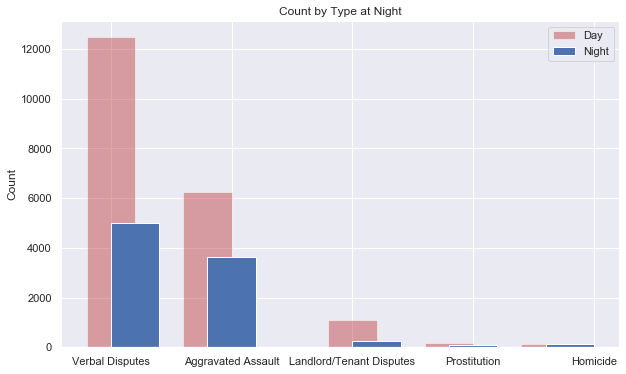

In [75]:
fig, ax = plt.subplots(figsize=(10,6))

# Normalize per # hours - 9 in night, 15 in day
ax.hist(crimes3['Crime_Type'][crimes3['NIGHT']==0], color='r', label='Day', align='left', alpha=0.5)
ax.hist(crimes3['Crime_Type'][crimes3['NIGHT']==1], label='Night')

ax.legend()

ax.set_title('Count by Type at Night')
ax.set_ylabel('Count')

plt.show()

Scatter Matrix of select predictors:

In [76]:
crimes3['Crime_Type_no'] = crimes3['Crime_Type'].map({
    'Verbal Disputes':1, 
    'Aggravated Assault':2, 
    'Landlord/Tenant Disputes':3, 
    'Prostitution':4, 
    'Homicide':5, 
})

In [77]:
crimes3.head()

,Unnamed: 0,Crime_Type,DISTRICT,REPORTING_,YEAR,MONTH,DAY_OF_WEE,HOUR,Lat,Long,Name,SqMiles,Police_Station_Distance,Public_School_Distance,Private_School_Distance,Library_Distance,Community_Center_Distance,College_Univ_Distance,Streetlight_Distance,Streetlight_Density,Property_Total,Property_Avg,Property_Var,NIGHT,Crime_Type_no
0,7,Verbal Disputes,1,450,2019,9,7,6,42.291816,-71.072441,Dorchester,7.29,1294.698734,573.079836,266.645536,493.022243,662.780790,1712.705604,6.699160,22.0,1.516038e+08,0.645123,5.377572e+11,0,1
1,11,Aggravated Assault,11,75,2019,9,7,4,42.364331,-71.063193,West End,0.30,365.995871,706.153883,850.480630,353.759022,722.748431,602.902936,6.413295,35.0,1.980411e+09,37.366238,2.107007e+16,1,2
2,14,Verbal Disputes,1,466,2019,9,6,23,42.283628,-71.093496,Mattapan,2.11,191.749246,191.631906,487.781032,679.592992,869.976099,2433.586111,74.517637,1.0,1.310139e+08,0.612215,1.842610e+12,1,1
3,16,Verbal Disputes,1,429,2019,9,7,0,42.285765,-71.087632,Dorchester,7.29,354.142836,410.533676,345.745917,1022.549119,949.870546,2071.275505,4.538379,14.0,1.094070e+08,0.441157,6.624002e+10,1,1
4,18,Verbal Disputes,3,311,2019,9,7,0,42.317859,-71.081036,Roxbury,3.29,1231.619915,342.035958,226.083006,1098.049354,908.139672,1736.328140,11.645008,18.0,1.099579e+08,0.588010,1.135150e+12,1,1


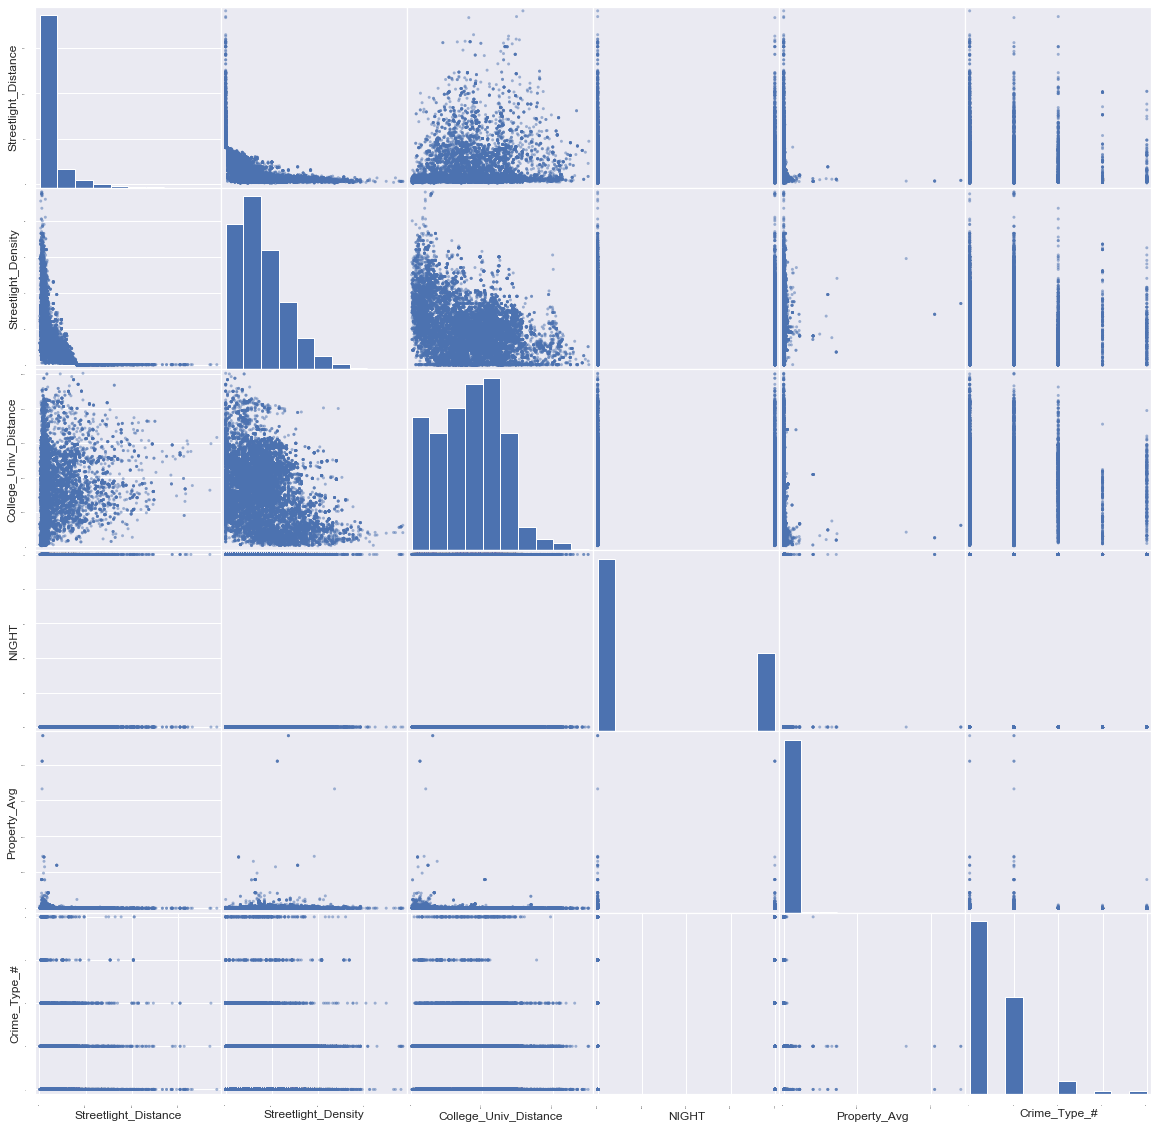

Wall time: 12.8 s


In [1073]:
%%time
pred_columns = ['Streetlight_Distance', 'Streetlight_Density', 'College_Univ_Distance',
                'NIGHT', 'Property_Avg', 'Crime_Type_no']


Axes = scatter_matrix(crimes3[pred_columns], alpha=0.5, figsize=(20, 20))
#y ticklabels
[plt.setp(item.yaxis.get_majorticklabels(), 'size', 2) for item in Axes.ravel()]
#x ticklabels
[plt.setp(item.xaxis.get_majorticklabels(), 'size', 2) for item in Axes.ravel()]

plt.show()

<hr style="height:2pt">

## Building Models

### Original Categories

In [17]:
crimes_full2.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'DISTRICT', 'REPORTING_', 'SHOOTING',
       'YEAR', 'MONTH', 'DAY_OF_WEE', 'HOUR', 'Lat', 'Long', 'Name', 'SqMiles',
       'Crime_Type_Break_In', 'Crime_Type_Drugs', 'Crime_Type_Larceny',
       'Crime_Type_Property_Damage', 'Crime_Type_Violent',
       'Police_Station_Distance', 'Public_School_Distance',
       'Private_School_Distance', 'Library_Distance',
       'Community_Center_Distance', 'College_Univ_Distance',
       'Streetlight_Distance', 'Streetlight_Density', 'Property_Total',
       'Property_Avg', 'Property_Var', 'NIGHT', 'Crime_Type'],
      dtype='object')

In [18]:
pred_only_columns = ['DISTRICT', 'Police_Station_Distance', 'Public_School_Distance',
                     'Private_School_Distance', 'Library_Distance', 
                     'Community_Center_Distance', 'College_Univ_Distance', 
                     'Streetlight_Distance', 'Streetlight_Density', 'Property_Avg', 'NIGHT']

In [86]:
pred_plus_cols = ['DISTRICT', 'Police_Station_Distance', 'Public_School_Distance',
                     'Private_School_Distance', 'Library_Distance', 
                     'Community_Center_Distance', 'College_Univ_Distance', 
                     'Streetlight_Distance', 'Streetlight_Density', 'Property_Avg', 'NIGHT', 'Crime_Type']

In [95]:
# Train/Test
np.random.seed(10)

X_train, X_test, y_train, y_test = train_test_split(crimes_full2[pred_only_columns], crimes_full2.Crime_Type, 
                                                    test_size=0.2, random_state = 109)

In [113]:
np.random.seed(10)

train, test = train_test_split(crimes_full2[pred_plus_cols], test_size=0.2, random_state = 109)

In [97]:
mX_train = np.array(X_train)
mX_test = np.array(X_test)
my_train = y_train.copy()
my_test = y_test.copy()

In [98]:
my_train[my_train=='Violent']=0
my_train[my_train=='Break_In']=1
my_train[my_train=='Larceny']=2
my_train[my_train=='Property_Damage']=3
my_train[my_train=='Drugs']=4

my_test[my_test=='Violent']=0
my_test[my_test=='Break_In']=1
my_test[my_test=='Larceny']=2
my_test[my_test=='Property_Damage']=3
my_test[my_test=='Drugs']=4

In [99]:
my_train = np.array(my_train.astype(dtype='int64'))
my_test = np.array(my_test.astype(dtype='int64'))

In [114]:
train['Crime_Type'][train['Crime_Type']=='Violent']=0
train['Crime_Type'][train['Crime_Type']=='Break_In']=1
train['Crime_Type'][train['Crime_Type']=='Larceny']=2
train['Crime_Type'][train['Crime_Type']=='Property_Damage']=3
train['Crime_Type'][train['Crime_Type']=='Drugs']=4

test['Crime_Type'][test['Crime_Type']=='Violent']=0
test['Crime_Type'][test['Crime_Type']=='Break_In']=1
test['Crime_Type'][test['Crime_Type']=='Larceny']=2
test['Crime_Type'][test['Crime_Type']=='Property_Damage']=3
test['Crime_Type'][test['Crime_Type']=='Drugs']=4

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing

In [115]:
train['Crime_Type'] = train['Crime_Type'].astype(dtype='int64')
test['Crime_Type'] = test['Crime_Type'].astype(dtype='int64')

Test accuracy score based on predicting everything as most common category:

In [105]:
len(y_test[y_test=='Larceny'])/len(y_test)

0.45646690440984605

45.65% will be the score to beat for the test data. Anything less will be inherently worse than just classifying everything as the most common category, 'Larceny.'

<hr style="height:1pt">

#### Logistic Regression

We trained logistic regression models to predict crime type based on various predictors.

Using Just Streetlight Distance:

In [21]:
# Fit logistic regression
logreg_stdist = LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs', max_iter=1000)
fit_logreg_stdist = logreg_stdist.fit(X_train[['Streetlight_Distance']], y_train)

pred_train_stdist = fit_logreg_stdist.predict(X_train[['Streetlight_Distance']])
pred_test_stdist = fit_logreg_stdist.predict(X_test[['Streetlight_Distance']])

print('Logistic Model on Streetlight Distance')

print('Train accuracy:', accuracy_score(y_train, pred_train_stdist))

print('Test accuracy:', accuracy_score(y_test, pred_test_stdist))

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Model on Streetlight Distance
Train accuracy: 0.4541827038075978
Test accuracy: 0.45546664347221016


Using just Streetlight Density:

In [22]:
# Fit logistic regression
logreg_stden = LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs', max_iter=1000)
fit_logreg_stden = logreg_stden.fit(X_train[['Streetlight_Density']], y_train)

pred_train_stden = fit_logreg_stden.predict(X_train[['Streetlight_Density']])
pred_test_stden = fit_logreg_stden.predict(X_test[['Streetlight_Density']])

print('Logistic Model on Streetlight Density')

print('Train accuracy:', accuracy_score(y_train, pred_train_stden))

print('Test accuracy:', accuracy_score(y_test, pred_test_stden))

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Model on Streetlight Density
Train accuracy: 0.45510687803074784
Test accuracy: 0.45646690440984605


Using all Predictors:

In [23]:
# Fit logistic regression
logreg_all = LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs', max_iter=1000)
fit_logreg_all = logreg_all.fit(X_train, y_train)

pred_train_all = fit_logreg_all.predict(X_train)
pred_test_all = fit_logreg_all.predict(X_test)

print('Logistic Model with All Predictors')

print('Train accuracy:', accuracy_score(y_train, pred_train_all))

print('Test accuracy:', accuracy_score(y_test, pred_test_all))

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Model with All Predictors
Train accuracy: 0.46339182812533974
Test accuracy: 0.46555623206053753


<hr style="height:1pt">

#### kNN Classifier

In [71]:
%%time
ks = [1,3,5,10,20,50,100,500]
k_scores = pd.DataFrame({'k':ks})
test_scores = []
train_scores = []

for i in ks:
    knn = KNeighborsClassifier(i)
    fit = knn.fit(mX_train, my_train)
    train_scores.append(fit.score(mX_train, my_train))
    test_scores.append(fit.score(mX_test, my_test))

k_scores['Train_Accuracy'] = train_scores.copy() 
k_scores['Test_Accuracy'] = test_scores.copy()

Wall time: 2min 25s


In [72]:
k_scores

,k,Train_Accuracy,Test_Accuracy
0,1,0.571716,0.433374
1,3,0.571814,0.455075
2,5,0.583393,0.480952
3,10,0.567910,0.494868
4,20,0.546568,0.500565
5,50,0.525051,0.505349
6,100,0.513091,0.504566
7,500,0.493596,0.494390


<hr style="height:1pt">

#### Decision Tree Classifier

In [74]:
depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):

    dt = DecisionTreeClassifier(max_depth=depths).fit(X_train, y_train)
    
    cv = cross_val_score(dt, X_train, y_train, cv=5)
    cvmeans = np.mean(cv)
    cvstds = np.std(cv)
    
    pred = dt.predict(X_train)
    train_scores = accuracy_score(y_train, pred)
    
    return cvmeans, cvstds, train_scores

In [75]:
cvmeans = np.zeros(20)
cvstds = np.zeros(20)
train_scores = np.zeros(20)

for i in depths:
    calc = calc_meanstd(X_train, y_train, i)
    cvmeans[i-1] = calc[0]
    cvstds[i-1] = calc[1]
    train_scores[i-1] = calc[2]


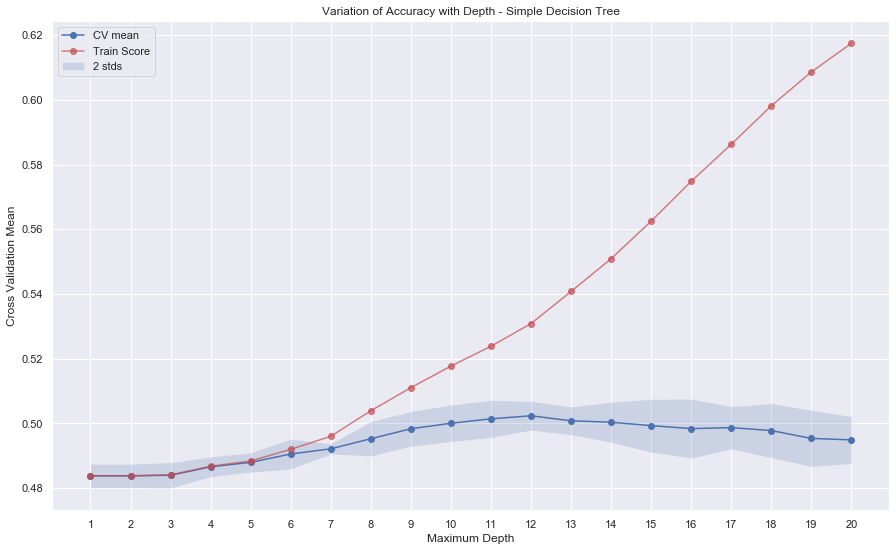

In [76]:
fig, ax = plt.subplots(1, figsize=(15,9))

ax.set_ylabel("Cross Validation Mean")
ax.set_xlabel("Maximum Depth")
ax.set_title('Variation of Accuracy with Depth - Simple Decision Tree')

ax.plot(range(1,21), cvmeans, 'b-', marker='o', label='CV mean')
ax.plot(range(1,21), train_scores, 'r-', marker='o', label='Train Score', alpha=0.7)
ax.fill_between(range(1,21), cvmeans + cvstds*2, cvmeans - cvstds*2, alpha=0.2, label='2 stds')

ax.legend()
ax.set_xticks(range(1,21))

plt.show()


In [174]:
#highest cv mean is at max depth of 9
best_tree = DecisionTreeClassifier(max_depth=12)
best_tree.fit(X_train, y_train)

best_cv_tree_train_score = accuracy_score(y_train, best_tree.predict(X_train))
best_cv_tree_test_score  = accuracy_score(y_test,  best_tree.predict(X_test))

print("Train Set Accuracy : {}".format(best_cv_tree_train_score))
print("Test Set Accuracy : {}".format(best_cv_tree_test_score))

Train Set Accuracy : 0.530823928501533
Test Set Accuracy : 0.5040010437505437


<hr style="height:1pt">

#### Bagging

In [109]:
def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_trees
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    # your code here
    
    bagging_train = np.zeros((train.shape[0], n_trees))
    bagging_test = np.zeros((test.shape[0], n_trees))
    
    bagging_models = []
    
    for i in range(n_trees):
        dt = DecisionTreeClassifier(max_depth=tree_depth)
        
        temp = train.sample(frac=1, replace=True)
        response_variable = temp['Crime_Type']
        temp = temp.drop(['Crime_Type'], axis=1)

        dt.fit(temp, response_variable)  
        bagging_models.append(dt)
        
        bagging_train[:,i] = dt.predict(mX_train)   
        bagging_test[:,i] = dt.predict(mX_test)
    
    bagging_train_df = pd.DataFrame(bagging_train)
    bagging_test_df = pd.DataFrame(bagging_test)
        
    return(bagging_train_df, bagging_test_df, bagging_models)

In [117]:
n_trees = 55

# Use optimal tree depth from decision tree classifier above
tree_depth = 12

bagging_train_df, bagging_test_df, bagging_models = bagger(n_trees, tree_depth,  random_seed= 0)
display(bagging_train_df.head())
display(bagging_test_df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,4.0,2.0,3.0,3.0,4.0,2.0,3.0,4.0,4.0,2.0,4.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,0.0,0.0,2.0,0.0,2.0,0.0,2.0,2.0,3.0,0.0,0.0,2.0,3.0,3.0,2.0,0.0,3.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,3.0,3.0,3.0,2.0,3.0,3.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0
3,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0
4,2.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,3.0,4.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0,0.0,2.0,2.0,2.0,2.0,3.0,2.0,3.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,2.0,4.0,2.0,2.0,4.0,2.0,4.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,4.0,2.0,3.0,0.0,0.0,4.0,2.0,2.0,4.0,2.0,4.0,0.0,2.0,4.0,4.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,3.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,4.0,4.0,2.0,4.0,2.0,2.0,0.0,3.0,3.0
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0
4,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [137]:
train_mode = stats.mode(bagging_train_df, axis=1)
test_mode = stats.mode(bagging_test_df, axis=1)

In [139]:
print('Train Accuracy: {}'.format(accuracy_score(train_mode[0], my_train)))
print('Test Accuracy: {}'.format(accuracy_score(test_mode[0], my_test)))

Train Accuracy: 0.5338356492052102
Test Accuracy: 0.5125250065234409


##### Variable Importance

In [160]:
bag_importances = np.zeros((55, 11))

for i in range(len(bagging_models)):
    for j in range(11):
        importance = bagging_models[i].feature_importances_[j]
        bag_importances[i, j] = importance/bagging_models[i].feature_importances_.max()

feature_importance_bag = np.mean(bag_importances, axis=0)
sorted_idx_bag = np.argsort(feature_importance_bag)

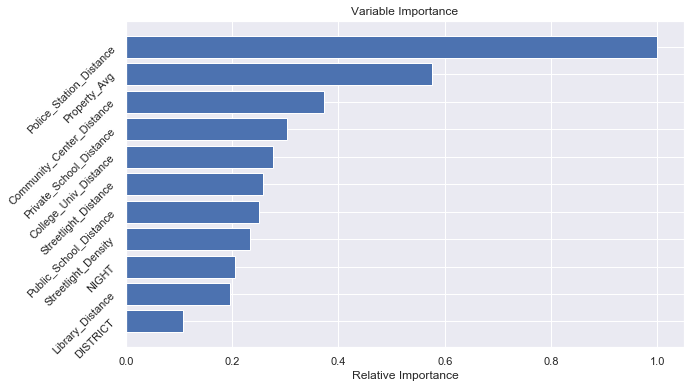

In [161]:
fig, ax = plt.subplots(1, figsize=(10,6))

pos_bag = np.arange(sorted_idx_bag.shape[0]) + 0.5

ax.barh(pos_bag, feature_importance_bag[sorted_idx_bag], align='center')
ax.set_xlabel('Relative Importance')
ax.set_title('Variable Importance')

yticks_bag = [ i for i in X_train.columns[sorted_idx_bag] ]
ax.set_yticks(pos_bag)
ax.set_yticklabels(yticks_bag, rotation=45, horizontalalignment='right')

plt.show()

<hr style="height:1pt">

#### Random Forest

In [185]:
fitted_rf = RandomForestClassifier(n_estimators=55, max_features='sqrt', max_depth=12).fit(mX_train,my_train)
random_forest_train_score = fitted_rf.score(mX_train, my_train)
random_forest_test_score = fitted_rf.score(mX_test, my_test)
print(f"The random forest scored {random_forest_train_score:.3f} on the train set.")
print(f"The random forest scored {random_forest_test_score:.3f} on the test set.")

The random forest scored 0.544 on the train set.
The random forest scored 0.514 on the test set.


##### Variable Importance

In [166]:
feature_importance_RF = fitted_rf.feature_importances_
feature_importance_RF = (feature_importance_RF / feature_importance_RF.max())
sorted_idx_RF = np.argsort(feature_importance_RF)

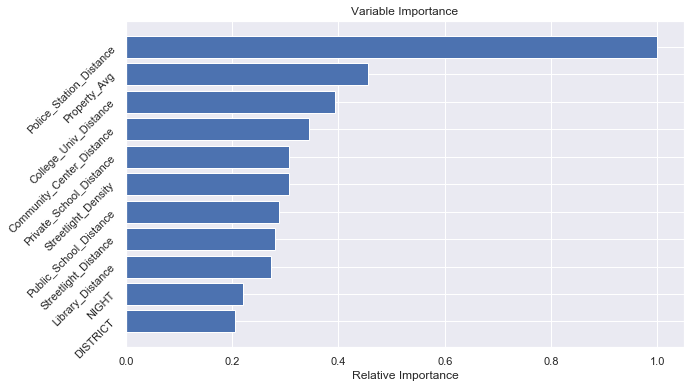

In [167]:
fig, ax = plt.subplots(1, figsize=(10,6))

pos_rf = np.arange(sorted_idx_RF.shape[0]) + 0.5

ax.barh(pos_rf, feature_importance_RF[sorted_idx_RF], align='center')
ax.set_xlabel('Relative Importance')
ax.set_title('Variable Importance')

yticks_bag = [ i for i in X_train.columns[sorted_idx_RF] ]
ax.set_yticks(pos_rf)
ax.set_yticklabels(yticks_bag, rotation=45, horizontalalignment='right')

plt.show()

<hr style="height:1pt">

#### Neural Network

In [27]:
model_m1 = tf.keras.models.Sequential()

model_m1.add(tf.keras.layers.Dense(100, activation='relu', input_shape=(11,)))
model_m1.add(tf.keras.layers.Dense(100, activation='relu'))
model_m1.add(tf.keras.layers.Dense(100, activation='relu'))
model_m1.add(tf.keras.layers.Dense(100, activation='relu'))
model_m1.add(tf.keras.layers.Dense(5, activation='softmax'))

In [28]:
model_m1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_m1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 32,005
Trainable params: 32,005
Non-trainable params: 0
_________________________________________________________________


In [29]:
%%time
fit_m1 = model_m1.fit(mX_train, my_train, epochs=2000, batch_size=128, verbose=0, validation_split=0.3)

Wall time: 35min 12s


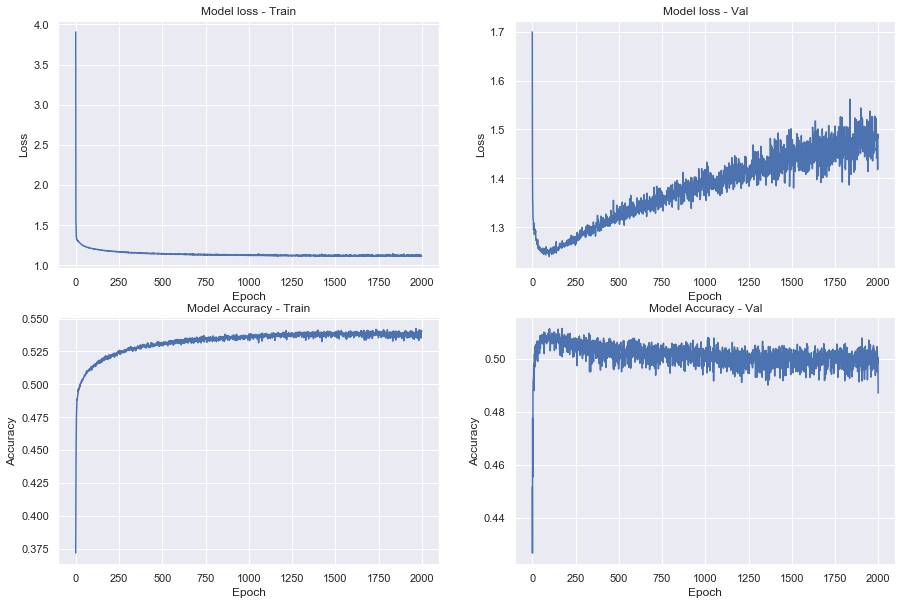

In [30]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))

ax[0, 0].plot(fit_m1.history['loss'],'b')
ax[0, 0].set_title('Model loss - Train')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].set_xlabel('Epoch')

ax[0, 1].plot(fit_m1.history['val_loss'],'b')
ax[0, 1].set_title('Model loss - Val')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].set_xlabel('Epoch')

ax[1, 0].plot(fit_m1.history['accuracy'],'b')
ax[1, 0].set_title('Model Accuracy - Train')
ax[1, 0].set_ylabel('Accuracy')
ax[1, 0].set_xlabel('Epoch')

ax[1, 1].plot(fit_m1.history['val_accuracy'],'b')
ax[1, 1].set_title('Model Accuracy - Val')
ax[1, 1].set_ylabel('Accuracy')
ax[1, 1].set_xlabel('Epoch')

plt.show()

In [31]:
print('Training Accuracy: {}'.format(np.max(fit_m1.history['accuracy'])))
print('Training Loss: {}'.format(np.min(fit_m1.history['loss'])))
print('Validation Accuracy: {}'.format(np.max(fit_m1.history['val_accuracy'])))
print('Validation Loss: {}'.format(np.min(fit_m1.history['val_loss'])))

Training Accuracy: 0.5424426198005676
Training Loss: 1.1071969146147551
Validation Accuracy: 0.5114340782165527
Validation Loss: 1.239539400818288


##### Variable Importance

In [32]:
preds_df = model_m1.predict(mX_train)

preds1 = np.zeros(len(preds_df))
for i in range(len(preds_df)):
    preds1[i] = np.argmax(preds_df[i])

In [33]:
dec_tree_NN = DecisionTreeClassifier(max_depth=20)
dec_tree_NN.fit(mX_train, preds1)

feature_importance_NN = dec_tree_NN.feature_importances_
feature_importance_NN = (feature_importance_NN / feature_importance_NN.max())
sorted_idx_NN = np.argsort(feature_importance_NN)

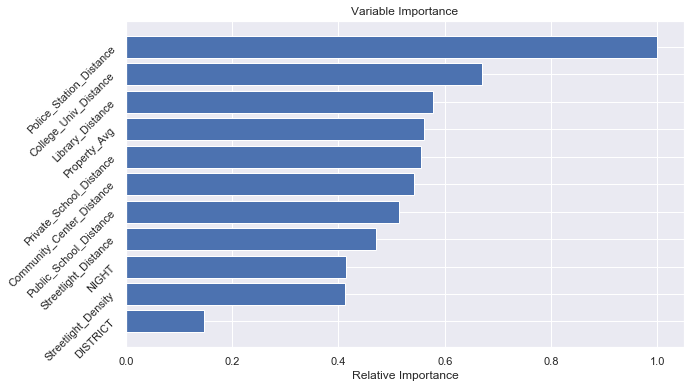

In [34]:
fig, ax = plt.subplots(1, figsize=(10,6))

pos_NN = np.arange(sorted_idx_NN.shape[0]) + .5

ax.barh(pos_NN, feature_importance_NN[sorted_idx_NN], align='center')
ax.set_xlabel('Relative Importance')
ax.set_title('Variable Importance')

yticks_NN = [ i for i in X_train.columns[sorted_idx_NN] ]
ax.set_yticks(pos_NN)
ax.set_yticklabels(yticks_NN, rotation=45, horizontalalignment='right')

plt.show()

<hr style="height:2pt">

### New Categories

In [35]:
crimes3.columns

Index(['Unnamed: 0', 'Crime_Type', 'DISTRICT', 'REPORTING_', 'YEAR', 'MONTH',
       'DAY_OF_WEE', 'HOUR', 'Lat', 'Long', 'Name', 'SqMiles',
       'Police_Station_Distance', 'Public_School_Distance',
       'Private_School_Distance', 'Library_Distance',
       'Community_Center_Distance', 'College_Univ_Distance',
       'Streetlight_Distance', 'Streetlight_Density', 'Property_Total',
       'Property_Avg', 'Property_Var', 'NIGHT'],
      dtype='object')

In [57]:
# Train/Test
np.random.seed(10)

X_train3, X_test3, y_train3, y_test3 = train_test_split(crimes3[pred_only_columns], crimes3.Crime_Type, 
                                                        test_size=0.2, random_state = 109)

In [118]:
np.random.seed(10)

train3, test3 = train_test_split(crimes3[pred_plus_cols], test_size=0.2, random_state = 109)

We converted the train/test sets to np arrays and encoded the crime categories:

In [41]:
mX_train3 = np.array(X_train3)
mX_test3 = np.array(X_test3)
my_train3 = y_train3.copy()
my_test3 = y_test3.copy()

In [123]:
my_train3[my_train3=='Landlord/Tenant Disputes']=0
my_train3[my_train3=='Prostitution']=1
my_train3[my_train3=='Verbal Disputes']=2
my_train3[my_train3=='Aggravated Assault']=3
my_train3[my_train3=='Homicide']=4

my_test3[my_test3=='Landlord/Tenant Disputes']=0
my_test3[my_test3=='Prostitution']=1
my_test3[my_test3=='Verbal Disputes']=2
my_test3[my_test3=='Aggravated Assault']=3
my_test3[my_test3=='Homicide']=4

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.
C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perf

In [124]:
my_train3 = np.array(my_train3.astype(dtype='int64'))
my_test3 = np.array(my_test3.astype(dtype='int64'))

In [121]:
train3['Crime_Type'][train3['Crime_Type']=='Landlord/Tenant Disputes']=0
train3['Crime_Type'][train3['Crime_Type']=='Prostitution']=1
train3['Crime_Type'][train3['Crime_Type']=='Verbal Disputes']=2
train3['Crime_Type'][train3['Crime_Type']=='Aggravated Assault']=3
train3['Crime_Type'][train3['Crime_Type']=='Homicide']=4

test3['Crime_Type'][test3['Crime_Type']=='Landlord/Tenant Disputes']=0
test3['Crime_Type'][test3['Crime_Type']=='Prostitution']=1
test3['Crime_Type'][test3['Crime_Type']=='Verbal Disputes']=2
test3['Crime_Type'][test3['Crime_Type']=='Aggravated Assault']=3
test3['Crime_Type'][test3['Crime_Type']=='Homicide']=4

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing

In [122]:
train3['Crime_Type'] = train3['Crime_Type'].astype(dtype='int64')
test3['Crime_Type'] = test3['Crime_Type'].astype(dtype='int64')

Test accuracy score based on predicting everything as most common category:

In [58]:
len(y_test3[y_test3=='Verbal Disputes'])/len(y_test3)

0.5906132237067488

59.06% will be the score to beat for the test data. Anything less will be inherently worse than just classifying everything as the most common category, 'Verbal Disputes.'

<hr style="height:1pt">

#### Logistic Regression

We trained logistic regression models to predict crime type based on various predictors.

Using Just Streetlight Distance:

In [59]:
# Fit logistic regression
logreg_stdist3 = LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs', max_iter=1000)
fit_logreg_stdist3 = logreg_stdist3.fit(X_train3[['Streetlight_Distance']], y_train3)

pred_train_stdist3 = fit_logreg_stdist3.predict(X_train3[['Streetlight_Distance']])
pred_test_stdist3 = fit_logreg_stdist3.predict(X_test3[['Streetlight_Distance']])

print('Logistic Model on Streetlight Distance')

print('Train accuracy:', accuracy_score(y_train3, pred_train_stdist3))

print('Test accuracy:', accuracy_score(y_test3, pred_test_stdist3))

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Model on Streetlight Distance
Train accuracy: 0.6019612881123673
Test accuracy: 0.5906132237067488


Using just Streetlight Density:

In [60]:
# Fit logistic regression
logreg_stden3 = LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs', max_iter=1000)
fit_logreg_stden3 = logreg_stden3.fit(X_train3[['Streetlight_Density']], y_train3)

pred_train_stden3 = fit_logreg_stden3.predict(X_train3[['Streetlight_Density']])
pred_test_stden3 = fit_logreg_stden3.predict(X_test3[['Streetlight_Density']])

print('Logistic Model on Streetlight Density')

print('Train accuracy:', accuracy_score(y_train3, pred_train_stden3))

print('Test accuracy:', accuracy_score(y_test3, pred_test_stden3))

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Model on Streetlight Density
Train accuracy: 0.6048732442617335
Test accuracy: 0.5986639260020555


Using all Predictors:

In [61]:
# Fit logistic regression
logreg_all3 = LogisticRegression(C=100000, fit_intercept=True, solver='lbfgs', max_iter=1000)
fit_logreg_all3 = logreg_all3.fit(X_train3, y_train3)

pred_train_all3 = fit_logreg_all3.predict(X_train3)
pred_test_all3 = fit_logreg_all3.predict(X_test3)

print('Logistic Model with All Predictors')

print('Train accuracy:', accuracy_score(y_train3, pred_train_all3))

print('Test accuracy:', accuracy_score(y_test3, pred_test_all3))

C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\hland\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Logistic Model with All Predictors
Train accuracy: 0.6304385063377869
Test accuracy: 0.6229873244261733


<hr style="height:1pt">

#### kNN Classifier

In [67]:
%%time
ks3 = [1,3,5,10,20,50,100,500]
k_scores3 = pd.DataFrame({'k':ks3})
test_scores3 = []
train_scores3 = []

for i in ks3:
    knn = KNeighborsClassifier(i)
    fit = knn.fit(mX_train3, my_train3)
    train_scores3.append(fit.score(mX_train3, my_train3))
    test_scores3.append(fit.score(mX_test3, my_test3))

k_scores3['Train_Accuracy'] = train_scores3.copy() 
k_scores3['Test_Accuracy'] = test_scores3.copy()

Wall time: 26.1 s


In [68]:
k_scores3

,k,Train_Accuracy,Test_Accuracy
0,1,0.769142,0.605002
1,3,0.747559,0.636691
2,5,0.736083,0.650223
3,10,0.711930,0.662042
4,20,0.686922,0.660843
5,50,0.666453,0.649880
6,100,0.656218,0.645769
7,500,0.638189,0.630867


<hr style="height:1pt">

#### Decision Tree Classifier

In [78]:
cvmeans3 = np.zeros(20)
cvstds3 = np.zeros(20)
train_scores_3 = np.zeros(20)

for i in depths:
    calc = calc_meanstd(X_train3, y_train3, i)
    cvmeans3[i-1] = calc[0]
    cvstds3[i-1] = calc[1]
    train_scores_3[i-1] = calc[2]


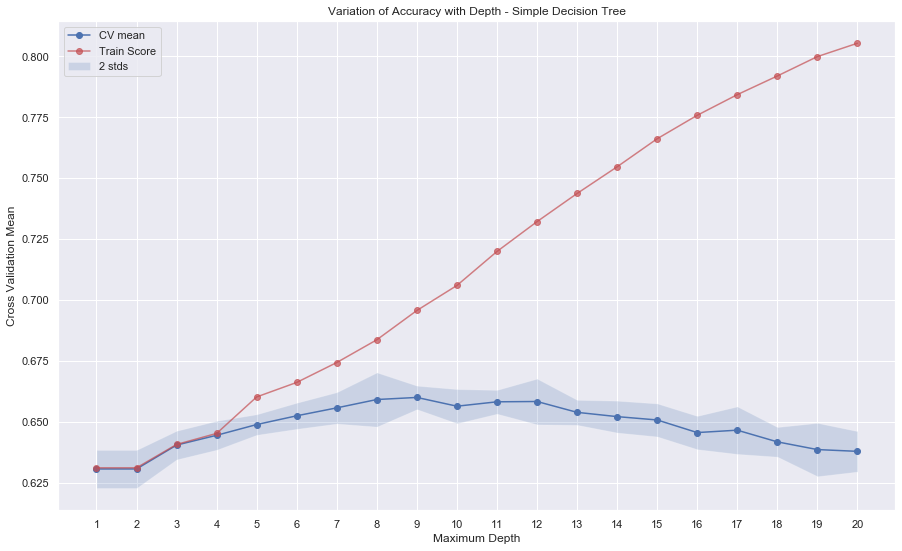

In [79]:
fig, ax = plt.subplots(1, figsize=(15,9))

ax.set_ylabel("Cross Validation Mean")
ax.set_xlabel("Maximum Depth")
ax.set_title('Variation of Accuracy with Depth - Simple Decision Tree')

ax.plot(range(1,21), cvmeans3, 'b-', marker='o', label='CV mean')
ax.plot(range(1,21), train_scores_3, 'r-', marker='o', label='Train Score', alpha=0.7)
ax.fill_between(range(1,21), cvmeans3 + cvstds3*2, cvmeans3 - cvstds3*2, alpha=0.2, label='2 stds')

ax.legend()
ax.set_xticks(range(1,21))

plt.show()


In [176]:
#highest cv mean is at max depth of 9
best_tree3 = DecisionTreeClassifier(max_depth=9)
best_tree3.fit(X_train3, y_train3)

best_cv_tree_train_score3 = accuracy_score(y_train3, best_tree3.predict(X_train3))
best_cv_tree_test_score3  = accuracy_score(y_test3,  best_tree3.predict(X_test3))

print("Train Set Accuracy : {}".format(best_cv_tree_train_score3))
print("Test Set Accuracy : {}".format(best_cv_tree_test_score3))


Train Set Accuracy : 0.6957005823912299
Test Set Accuracy : 0.6628982528263104


<hr style="height:1pt">

#### Bagging

In [119]:
def bagger3(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_trees
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    # your code here
    
    bagging_train = np.zeros((train3.shape[0], n_trees))
    bagging_test = np.zeros((test3.shape[0], n_trees))
    
    bagging_models = []
    
    for i in range(n_trees):
        dt = DecisionTreeClassifier(max_depth=tree_depth)
        
        temp = train3.sample(frac=1, replace=True)
        response_variable = temp['Crime_Type']
        temp = temp.drop(['Crime_Type'], axis=1)

        dt.fit(temp, response_variable)  
        bagging_models.append(dt)
        
        bagging_train[:,i] = dt.predict(mX_train3)   
        bagging_test[:,i] = dt.predict(mX_test3)
    
    bagging_train_df = pd.DataFrame(bagging_train)
    bagging_test_df = pd.DataFrame(bagging_test)
        
    return(bagging_train_df, bagging_test_df, bagging_models)

In [125]:
n_trees = 55

# Use optimal tree depth from decision tree classifier above
tree_depth = 9

bagging_train_df3, bagging_test_df3, bagging_models3 = bagger3(n_trees, tree_depth,  random_seed= 0)
display(bagging_train_df3.head())
display(bagging_test_df3.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0
2,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,3.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,3.0
1,2.0,3.0,3.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,3.0,2.0,3.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0
2,3.0,2.0,3.0,2.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0,2.0,3.0,0.0,2.0,3.0,2.0,3.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0,3.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0
3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [146]:
train_mode3 = stats.mode(bagging_train_df3, axis=1)
test_mode3 = stats.mode(bagging_test_df3, axis=1)

In [147]:
print('Train Accuracy: {}'.format(accuracy_score(train_mode3[0], my_train3)))
print('Test Accuracy: {}'.format(accuracy_score(test_mode3[0], my_test3)))

Train Accuracy: 0.69741349777321
Test Accuracy: 0.6632408359027064


##### Variable Importance

In [168]:
bag_importancess3 = np.zeros((55, 11))

for i in range(len(bagging_models3)):
    for j in range(11):
        importances3 = bagging_models3[i].feature_importances_[j]
        bag_importancess3[i, j] = importances3/bagging_models3[i].feature_importances_.max()

feature_importance_bags3 = np.mean(bag_importancess3, axis=0)
sorted_idx_bags3 = np.argsort(feature_importance_bags3)

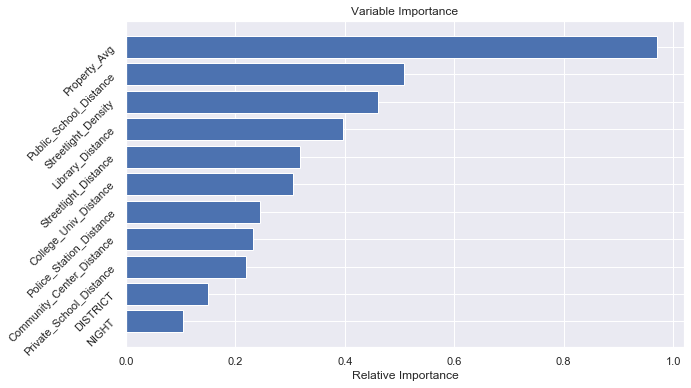

In [169]:
fig, ax = plt.subplots(1, figsize=(10,6))

pos_bag3 = np.arange(sorted_idx_bags3.shape[0]) + 0.5

ax.barh(pos_bag3, feature_importance_bags3[sorted_idx_bags3], align='center')
ax.set_xlabel('Relative Importance')
ax.set_title('Variable Importance')

yticks_bag3 = [ i for i in X_train3.columns[sorted_idx_bags3] ]
ax.set_yticks(pos_bag3)
ax.set_yticklabels(yticks_bag3, rotation=45, horizontalalignment='right')

plt.show()

<hr style="height:1pt">

#### Random Forest

In [184]:
fitted_rf3 = RandomForestClassifier(n_estimators=55, max_features='sqrt', max_depth=12).fit(mX_train3,my_train3)
random_forest_train_score3 = fitted_rf3.score(mX_train3, my_train3)
random_forest_test_score3 = fitted_rf3.score(mX_test3, my_test3)
print(f"The random forest scored {random_forest_train_score3:.3f} on the train set.")
print(f"The random forest scored {random_forest_test_score3:.3f} on the test set.")

The random forest scored 0.736 on the train set.
The random forest scored 0.671 on the test set.


##### Variable Importance

In [192]:
feature_importance_RF3 = fitted_rf3.feature_importances_
feature_importance_RF3 = (feature_importance_RF3 / feature_importance_RF3.max())
sorted_idx_RF3 = np.argsort(feature_importance_RF3)

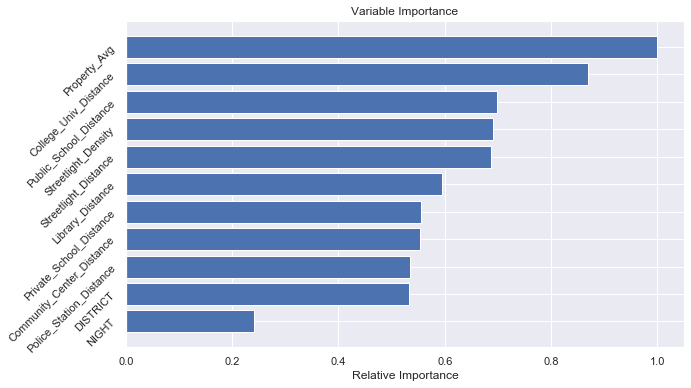

In [193]:
fig, ax = plt.subplots(1, figsize=(10,6))

pos_rf3 = np.arange(sorted_idx_RF3.shape[0]) + 0.5

ax.barh(pos_rf3, feature_importance_RF3[sorted_idx_RF3], align='center')
ax.set_xlabel('Relative Importance')
ax.set_title('Variable Importance')

yticks_bag3 = [ i for i in X_train3.columns[sorted_idx_RF3] ]
ax.set_yticks(pos_rf3)
ax.set_yticklabels(yticks_bag3, rotation=45, horizontalalignment='right')

plt.show()

<hr style="height:1pt">

#### Neural Network

##### Overfit Model

In [88]:
model_m3 = tf.keras.models.Sequential()

model_m3.add(tf.keras.layers.Dense(100, activation='relu', input_shape=(11,)))
model_m3.add(tf.keras.layers.Dense(100, activation='relu'))
model_m3.add(tf.keras.layers.Dense(100, activation='relu'))
model_m3.add(tf.keras.layers.Dense(100, activation='relu'))
model_m3.add(tf.keras.layers.Dense(5, activation='softmax'))

In [89]:
model_m3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_m3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               1200      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 505       
Total params: 32,005
Trainable params: 32,005
Non-trainable params: 0
_________________________________________________________________


In [90]:
%%time
fit_m3 = model_m3.fit(mX_train3, my_train3, epochs=2000, batch_size=128, verbose=0, validation_split=0.3)

Wall time: 10min 22s


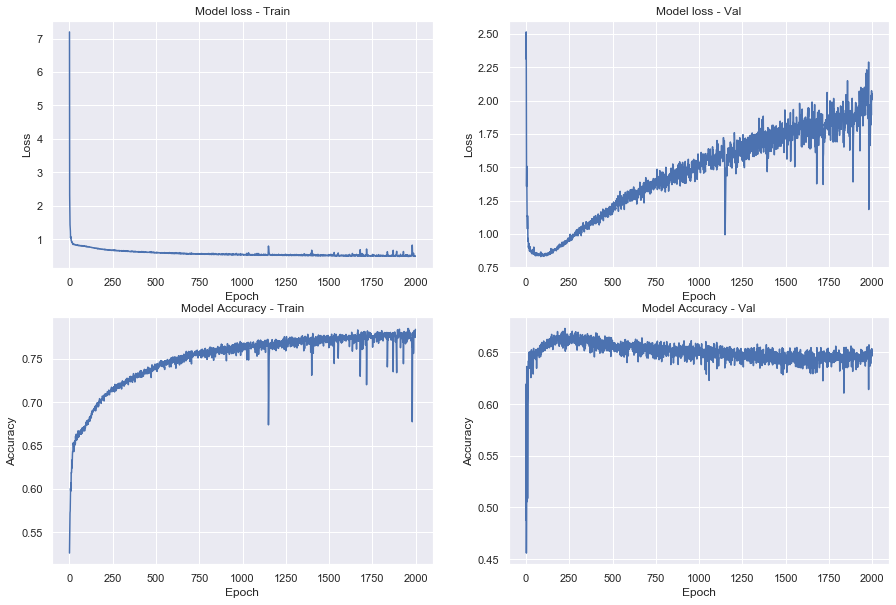

In [91]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))

ax[0, 0].plot(fit_m3.history['loss'],'b')
ax[0, 0].set_title('Model loss - Train')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].set_xlabel('Epoch')

ax[0, 1].plot(fit_m3.history['val_loss'],'b')
ax[0, 1].set_title('Model loss - Val')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].set_xlabel('Epoch')

ax[1, 0].plot(fit_m3.history['accuracy'],'b')
ax[1, 0].set_title('Model Accuracy - Train')
ax[1, 0].set_ylabel('Accuracy')
ax[1, 0].set_xlabel('Epoch')

ax[1, 1].plot(fit_m3.history['val_accuracy'],'b')
ax[1, 1].set_title('Model Accuracy - Val')
ax[1, 1].set_ylabel('Accuracy')
ax[1, 1].set_xlabel('Epoch')

plt.show()

In [92]:
print('Training Accuracy: {}'.format(np.max(fit_m3.history['accuracy'])))
print('Training Loss: {}'.format(np.min(fit_m3.history['loss'])))
print('Validation Accuracy: {}'.format(np.max(fit_m3.history['val_accuracy'])))
print('Validation Loss: {}'.format(np.min(fit_m3.history['val_loss'])))

Training Accuracy: 0.78490149974823
Training Loss: 0.47778557453367887
Validation Accuracy: 0.6731373071670532
Validation Loss: 0.8297686473049847


##### Regularized Model

In [44]:
model_r3 = tf.keras.models.Sequential()

kernel_weight = 0.003
bias_weight = 0.003

model_r3.add(tf.keras.layers.Dense(100, activation='relu', input_shape=(11,)))
model_r3.add(tf.keras.layers.Dense(100, activation='relu'))
model_r3.add(tf.keras.layers.Dense(100, activation='relu'))
model_r3.add(tf.keras.layers.Dense(100, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(kernel_weight), 
                                    bias_regularizer=tf.keras.regularizers.l2(bias_weight)))

model_r3.add(tf.keras.layers.Dropout(0.2))

model_r3.add(tf.keras.layers.Dense(5, activation='softmax'))

In [45]:
model_r3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_r3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               1200      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 505       
Total params: 32,005
Trainable params: 32,005
Non-trainable params: 0
__________________________________________________

In [46]:
%%time
fit_r3 = model_r3.fit(mX_train3, my_train3, epochs=2000, batch_size=128, verbose=0, validation_split=0.3)

Wall time: 10min 43s


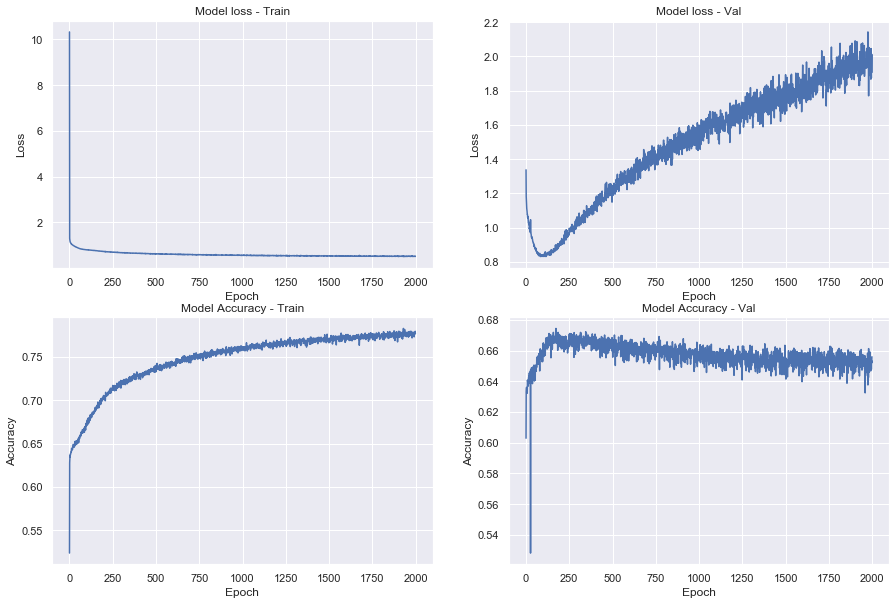

In [47]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))

ax[0, 0].plot(fit_r3.history['loss'],'b')
ax[0, 0].set_title('Model loss - Train')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].set_xlabel('Epoch')

ax[0, 1].plot(fit_r3.history['val_loss'],'b')
ax[0, 1].set_title('Model loss - Val')
ax[0, 1].set_ylabel('Loss')
ax[0, 1].set_xlabel('Epoch')

ax[1, 0].plot(fit_r3.history['accuracy'],'b')
ax[1, 0].set_title('Model Accuracy - Train')
ax[1, 0].set_ylabel('Accuracy')
ax[1, 0].set_xlabel('Epoch')

ax[1, 1].plot(fit_r3.history['val_accuracy'],'b')
ax[1, 1].set_title('Model Accuracy - Val')
ax[1, 1].set_ylabel('Accuracy')
ax[1, 1].set_xlabel('Epoch')

plt.show()

In [48]:
print('Training Accuracy: {}'.format(np.max(fit_r3.history['accuracy'])))
print('Training Loss: {}'.format(np.min(fit_r3.history['loss'])))
print('Validation Accuracy: {}'.format(np.max(fit_r3.history['val_accuracy'])))
print('Validation Loss: {}'.format(np.min(fit_r3.history['val_loss'])))

Training Accuracy: 0.782943844795227
Training Loss: 0.49520518157526777
Validation Accuracy: 0.6744219064712524
Validation Loss: 0.8304792341422327


##### Variable Importance

In [49]:
preds_df3 = model_r3.predict(mX_train3)

preds3 = np.zeros(len(preds_df3))
for i in range(len(preds_df3)):
    preds3[i] = np.argmax(preds_df3[i])

In [50]:
dec_tree_NN3 = DecisionTreeClassifier(max_depth=20)
dec_tree_NN3.fit(mX_train3, preds3)

feature_importance_NN3 = dec_tree_NN3.feature_importances_
feature_importance_NN3 = (feature_importance_NN3 / feature_importance_NN3.max())
sorted_idx_NN3 = np.argsort(feature_importance_NN3)

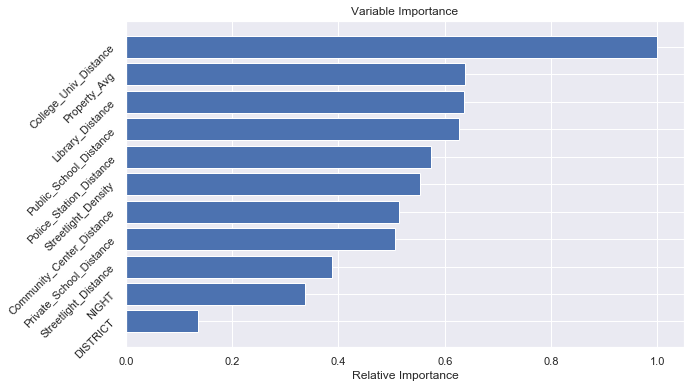

In [51]:
fig, ax = plt.subplots(1, figsize=(10,6))

pos_NN3 = np.arange(sorted_idx_NN3.shape[0]) + .5

ax.barh(pos_NN3, feature_importance_NN3[sorted_idx_NN3], align='center')
ax.set_xlabel('Relative Importance')
ax.set_title('Variable Importance')

yticks_NN3 = [ i for i in X_train3.columns[sorted_idx_NN3] ]
ax.set_yticks(pos_NN3)
ax.set_yticklabels(yticks_NN3, rotation=45, horizontalalignment='right')

plt.show()

<hr style="height:2pt">

## Results

### Original Categories

In [188]:
models = ['Logistic - Streetlight Density', 'Logistic - All', 'kNN', 
          'Decision Tree', 'Bagging', 'Random Forest', 'Neural Network']

train_results = [accuracy_score(y_train, pred_train_stden), accuracy_score(y_train, pred_train_all), 
                 k_scores['Train_Accuracy'].max(), best_cv_tree_train_score, accuracy_score(train_mode[0], my_train),
                random_forest_train_score, np.max(fit_m1.history['accuracy'])]

test_results = [accuracy_score(y_test, pred_test_stden), accuracy_score(y_test, pred_test_all), 
                k_scores['Test_Accuracy'].max(), best_cv_tree_test_score, accuracy_score(test_mode[0], my_test),
               random_forest_test_score, np.max(fit_m1.history['val_accuracy'])]

orig_results = pd.DataFrame({'Model':models, 'Best_Test_Accuracy':test_results, 'Train_Accuracy':train_results})

In [189]:
orig_results

,Model,Best_Test_Accuracy,Train_Accuracy
0,Logistic - Streetlight Density,0.456467,0.455107
1,Logistic - All,0.465556,0.463392
2,kNN,0.505349,0.583393
3,Decision Tree,0.504001,0.530824
4,Bagging,0.512525,0.533836
5,Random Forest,0.513786,0.544295
6,Neural Network,0.511434,0.542443


### New Categories

In [190]:
train_results3 = [accuracy_score(y_train3, pred_train_stden3), accuracy_score(y_train3, pred_train_all3), 
                 k_scores3['Train_Accuracy'].max(), best_cv_tree_train_score3, accuracy_score(train_mode3[0], my_train3),
                random_forest_train_score3, np.max(fit_r3.history['accuracy'])]

test_results3 = [accuracy_score(y_test3, pred_test_stden3), accuracy_score(y_test3, pred_test_all3), 
                k_scores3['Test_Accuracy'].max(), best_cv_tree_test_score3, accuracy_score(test_mode3[0], my_test3),
               random_forest_test_score3, np.max(fit_r3.history['val_accuracy'])]

new_results = pd.DataFrame({'Model':models, 'Best_Test_Accuracy':test_results3, 'Train_Accuracy':train_results3})

In [191]:
new_results

,Model,Best_Test_Accuracy,Train_Accuracy
0,Logistic - Streetlight Density,0.598664,0.604873
1,Logistic - All,0.622987,0.630439
2,kNN,0.662042,0.769142
3,Decision Tree,0.662898,0.695701
4,Bagging,0.663241,0.697413
5,Random Forest,0.671120,0.735697
6,Neural Network,0.674422,0.782944
